# Named Entity Recognition on CoNLL-2003 with Transformer-based Models

Fine-tune multiple transformer-based models on the CoNLL-2003 dataset for NER, evaluate performance, and compare efficiency.

## 1. Import Libraries

In [ ]:
# !pip install evaluate
# !pip install seqeval

In [ ]:
import torch
from datasets import load_dataset
from evaluate import load
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import os
import time
from transformers import (
    AutoTokenizer, 
    AutoModelForTokenClassification,
    TrainingArguments, 
    Trainer, 
    DataCollatorForTokenClassification,
    EarlyStoppingCallback
)

os.environ["WANDB_DISABLED"] = "true"



## 2. Set Random Seed
Ensures reproducibility for both CPU and GPU computations.

In [3]:
# set random seed for reproducibility
SEED = 42

torch.manual_seed(SEED)  # Ensure reproducibility for CPU and GPU operations
torch.cuda.manual_seed(SEED)  # Set seed for GPU computations
torch.cuda.manual_seed_all(SEED)  #  Ensure consistency across multiple GPUs

# Ensure deterministic behavior in CuDNN computations
torch.backends.cudnn.deterministic = True  # Force deterministic algorithms in CuDNN
torch.backends.cudnn.benchmark = False  # Disable benchmark mode for reproducibility


## 3. Define Model Configurations

In [4]:
# Model configurations
MODEL_CONFIGS = {
    'bert': {
        'name': 'bert-base-cased',
        'batch_size': 16,
        'learning_rate': 2e-5
    },
    'distilbert': {
    'name': 'distilbert-base-cased',
    'batch_size': 16,
    'learning_rate': 3e-5
    },
    'albert': {
        'name': 'albert-base-v2',
        'batch_size': 16,
        'learning_rate': 2e-5
    },
    'deberta': {
        'name': 'microsoft/deberta-v3-base',
        'batch_size': 16,
        'learning_rate': 2e-5
    },
}

# Common training parameters
COMMON_PARAMS = {
    'num_epochs': 10,
    'weight_decay': 0.01,
    'label_all_tokens': True
}



## 4. Functions for Data Processing, Training, and Evaluation

In [ ]:
def load_and_preprocess_data():
    """Load CoNLL-2003 dataset and prepare label list"""
    datasets = load_dataset("conll2003", trust_remote_code=True)
    
    # # for quick test
    # for split in ["train", "validation", "test"]:
    #     datasets[split] = datasets[split].train_test_split(test_size=0.95, seed=42)["train"]
        
    label_list = datasets["train"].features["ner_tags"].feature.names
    return datasets, label_list

In [ ]:
def tokenize_and_align_labels(examples, tokenizer, task="ner"):
    """Tokenize inputs and align labels"""
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True, 
        # max_length=128,    # set max_length
        # padding="max_length", 
        is_split_into_words=True
    )

    labels = []
    for i, label in enumerate(examples[f"{task}_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(label[word_idx] if COMMON_PARAMS['label_all_tokens'] else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [6]:
def prepare_model_and_trainer(model_config, num_labels, tokenized_datasets, tokenizer):
    """Prepare model, training arguments and trainer"""
    model_name = model_config['name']
    
    # Initialize model and tokenizer
    model = AutoModelForTokenClassification.from_pretrained(
        model_name,
        num_labels=num_labels
    )
    
    # Training arguments
    training_args = TrainingArguments(
        f"{model_name}-finetuned-ner",
        logging_strategy="epoch",
        eval_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=1,    # save HDD space
        learning_rate=model_config['learning_rate'],
        per_device_train_batch_size=model_config['batch_size'],
        per_device_eval_batch_size=model_config['batch_size'],
        # per_device_eval_batch_size=2,
        num_train_epochs=COMMON_PARAMS['num_epochs'],
        weight_decay=COMMON_PARAMS['weight_decay'],
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        max_grad_norm=1.0,
        report_to="none",
        # fp16=True,  # P100 does not support fp16
        # bf16=True,  # try bf16
        seed=SEED,
    )
    
    class CustomTrainer(Trainer):
        def evaluation_loop(self, *args, **kwargs):
            # empty cache before eval
            torch.cuda.empty_cache()
            return super().evaluation_loop(*args, **kwargs)
    
    # Initialize trainer
    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        data_collator=DataCollatorForTokenClassification(tokenizer),
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )
    
    return trainer

In [7]:
def compute_metrics(p):
    """Compute NER metrics"""
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
    
    batch_size = 100
    true_predictions = []
    true_labels = []
    
    for i in range(0, len(predictions), batch_size):
        batch_preds = predictions[i:i + batch_size]
        batch_labels = labels[i:i + batch_size]
        
        # Process batch predictions and labels
        true_predictions.extend([
            [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(batch_preds, batch_labels)
        ])
        true_labels.extend([
            [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(batch_preds, batch_labels)
        ])
        
        # Clean up GPU memory
        del batch_preds
        del batch_labels
        torch.cuda.empty_cache()

    # Set zero_division=0 to handle cases with no predicted samples
    results = metric.compute(predictions=true_predictions, references=true_labels, zero_division=0)
    
    # Extract detailed results for each entity type
    detailed_results = {}
    for entity_type, metrics in results.items():
        if entity_type not in ['overall_precision', 'overall_recall', 'overall_f1', 'overall_accuracy']:
            detailed_results[entity_type] = {
                'precision': round(float(metrics['precision']), 3),
                'recall': round(float(metrics['recall']), 3),
                'f1': round(float(metrics['f1']), 3)
            }
    
    return {
        "precision": float(results["overall_precision"]),
        "recall": float(results["overall_recall"]),
        "f1": float(results["overall_f1"]),
        "accuracy": float(results["overall_accuracy"]),
        "detailed_results": detailed_results
    }

In [8]:
def plot_training_curves(trainer, model_name):
    """Plot training and validation curves"""
    logs = trainer.state.log_history
    
    # Extract metrics with proper matching
    train_metrics = []
    eval_metrics = []
    
    current_epoch = 0
    current_metrics = {}
    
    for entry in logs:
        # Handle training logs
        if 'epoch' in entry:
            current_epoch = entry['epoch']
            if 'loss' in entry and 'eval_loss' not in entry:
                current_metrics['train_loss'] = entry['loss']
            elif 'eval_loss' in entry:
                current_metrics['eval_loss'] = entry['eval_loss']
                current_metrics['eval_f1'] = entry.get('eval_f1', None)
                
                # Store complete epoch data
                if 'train_loss' in current_metrics:
                    train_metrics.append((current_epoch, current_metrics['train_loss']))
                    eval_metrics.append((current_epoch, current_metrics['eval_loss'], current_metrics['eval_f1']))
                current_metrics = {}
    
    # Create plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    epochs = [x[0] for x in train_metrics]
    train_losses = [x[1] for x in train_metrics]
    eval_losses = [x[1] for x in eval_metrics]
    f1_scores = [x[2] for x in eval_metrics]
    
    ax1.plot(epochs, train_losses, label="Train Loss", marker="o")
    ax1.plot(epochs, eval_losses, label="Validation Loss", marker="o")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.set_title(f"{model_name} - Training & Validation Loss")
    ax1.legend()
    ax1.grid(True)
    
    # Plot F1 scores
    ax2.plot(epochs, f1_scores, label="F1-score", marker="o")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("F1-score")
    ax2.set_title(f"{model_name} - Validation F1-score")
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

In [9]:
def plot_confusion_matrix_with_token_metrics(true_label_ids, pred_label_ids, label_list, model_name):
    """Plot confusion matrix and calculate token-level metrics for entity type predictions"""
    # Convert predicted and true label indices to label names
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(pred_label_ids, true_label_ids)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(pred_label_ids, label) if l != -100]
        for prediction, label in zip(pred_label_ids, true_label_ids)
    ]
    
    # Flatten lists
    flat_predictions = [item for sublist in true_predictions for item in sublist]
    flat_true_labels = [item for sublist in true_labels for item in sublist]
    
    # Create confusion matrix
    cm = confusion_matrix(flat_true_labels, flat_predictions, labels=label_list)
    
    # Calculate token-level metrics for each class, excluding 'O'
    token_metrics = {}
    n_classes = len(label_list)
    
    # Initialize micro-averaging counters
    total_tp = 0
    total_fp = 0
    total_fn = 0
    
    for i in range(n_classes):
        if label_list[i] != 'O':  # Skip 'O' tag
            # True Positives: diagonal elements
            tp = cm[i, i]
            # False Positives: sum of column minus diagonal
            fp = np.sum(cm[:, i]) - tp
            # False Negatives: sum of row minus diagonal
            fn = np.sum(cm[i, :]) - tp
            
            # Accumulate for micro-averaging
            total_tp += tp
            total_fp += fp
            total_fn += fn
            
            # Store individual class metrics
            token_metrics[label_list[i]] = {
                'tp': tp,
                'fp': fp,
                'fn': fn
            }
    
    # Calculate micro-averaged metrics (excluding 'O' tag)
    micro_precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    micro_recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
    micro_f1 = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall) if (micro_precision + micro_recall) > 0 else 0
    
    # Calculate overall token-level accuracy (including 'O' for completeness)
    total_tp_all = np.sum(np.diag(cm))
    total_elements = np.sum(cm)
    overall_accuracy = total_tp_all / total_elements
    
    # Normalize confusion matrix for visualization
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot confusion matrices
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Raw counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_list, yticklabels=label_list, ax=ax1)
    ax1.set_title(f'Confusion Matrix (Raw Counts) - {model_name}')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('True')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
    ax1.set_yticklabels(ax1.get_yticklabels(), rotation=45)
    
    # Normalized
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=label_list, yticklabels=label_list, ax=ax2)
    ax2.set_title(f'Confusion Matrix (Normalized) - {model_name}')
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('True')
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
    ax2.set_yticklabels(ax2.get_yticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print token-level metrics
    print(f"\n=== Token-level Metrics for {model_name} (Micro-averaged, excluding 'O') ===")
    print(f"\nMicro-averaged Precision: {micro_precision:.3f}")
    print(f"Micro-averaged Recall: {micro_recall:.3f}")
    print(f"Micro-averaged F1: {micro_f1:.3f}")
    print(f"Overall Accuracy (including 'O'): {overall_accuracy:.3f}")
    
    # Print class distribution
    print(f"\nClass Distribution:")
    total_samples = len(flat_true_labels)
    distribution_df = pd.DataFrame({
        'Count': [flat_true_labels.count(label) for label in label_list],
        'Percentage': [flat_true_labels.count(label) / total_samples * 100 for label in label_list]
    }, index=label_list)
    distribution_df['Percentage'] = distribution_df['Percentage'].round(2)
    print(distribution_df)
    
    return {
        'token_metrics': token_metrics,
        'overall_metrics': {
            'accuracy': overall_accuracy,
            'micro_precision': micro_precision,
            'micro_recall': micro_recall,
            'micro_f1': micro_f1
        }
    }

In [10]:
def plot_misclassification_heatmap(true_label_ids, pred_label_ids, label_list, model_name):
    """
    Create a heatmap showing the most common misclassification patterns based on confusion matrix.
    """
    # Convert predicted and true label indices to label names
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(pred_label_ids, true_label_ids)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(pred_label_ids, label) if l != -100]
        for prediction, label in zip(pred_label_ids, true_label_ids)
    ]
    
    # Flatten lists
    flat_predictions = [item for sublist in true_predictions for item in sublist]
    flat_true_labels = [item for sublist in true_labels for item in sublist]
    
    # Create confusion matrix
    cm = confusion_matrix(flat_true_labels, flat_predictions, labels=label_list)
    
    # Create misclassification matrix by zeroing out the diagonal (correct predictions)
    misclass_cm = cm.copy()
    np.fill_diagonal(misclass_cm, 0)
    
    # Create a mask for the diagonal to highlight misclassifications
    mask = np.eye(len(label_list), dtype=bool)
    
    # Filter out 'O' class if it exists for better visualization of named entities
    o_idx = -1
    if 'O' in label_list:
        o_idx = label_list.index('O')
    
    # Create filtered versions without 'O' class for entity-focused analysis
    if o_idx >= 0:
        entity_labels = [label for i, label in enumerate(label_list) if i != o_idx]
        entity_cm = np.delete(np.delete(misclass_cm, o_idx, axis=0), o_idx, axis=1)
        entity_mask = np.delete(np.delete(mask, o_idx, axis=0), o_idx, axis=1)
    else:
        entity_labels = label_list
        entity_cm = misclass_cm
        entity_mask = mask
    
    # Create the plot
    plt.figure(figsize=(20, 8))
    
    # Plot 1: Full misclassification matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(misclass_cm, annot=True, fmt='d', cmap='Reds', 
                xticklabels=label_list, yticklabels=label_list, mask=mask)
    plt.title(f'Misclassification Matrix (excluding diagonal) - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45)
    
    # Plot 2: Entity-only misclassification with relative frequencies
    plt.subplot(1, 2, 2)
    
    # If we have entity-only data to plot
    if len(entity_labels) > 1:
        # Calculate relative frequencies
        # For each true entity, what % of its misclassifications are to each other entity
        row_sums = entity_cm.sum(axis=1)[:, np.newaxis]
        # Avoid division by zero
        row_sums[row_sums == 0] = 1
        entity_cm_norm = entity_cm.astype('float') / row_sums
        
        # Plot normalized misclassification heatmap 
        sns.heatmap(entity_cm_norm, annot=True, fmt='.1%', cmap='Reds', 
                    xticklabels=entity_labels, yticklabels=entity_labels, mask=entity_mask)
        plt.title(f'Entity Misclassification Rates - {model_name}')
        plt.xlabel('Predicted Entity')
        plt.ylabel('True Entity')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=45)
    else:
        plt.text(0.5, 0.5, "No entity-only data available", 
                 horizontalalignment='center', verticalalignment='center')
    
    plt.tight_layout()
    plt.show()
    
    # Now create a more detailed error analysis table
    error_analysis = []
    for i, true_label in enumerate(label_list):
        if true_label == 'O':
            continue  # Skip 'O' class
            
        # Total instances of this entity
        total = cm[i].sum()
        if total == 0:
            continue
            
        # Correct predictions
        correct = cm[i, i]
        
        # Calculate confusion with other entities
        confusions = {}
        for j, pred_label in enumerate(label_list):
            if i != j and cm[i, j] > 0:
                confusions[pred_label] = cm[i, j]
        
        # Top 3 most common misclassifications
        top_confusions = sorted(confusions.items(), key=lambda x: x[1], reverse=True)[:3]
        confusion_str = ", ".join([f"{label}: {count} ({count/total:.1%})" 
                                 for label, count in top_confusions])
        
        error_analysis.append({
            'Entity': true_label,
            'Total': total,
            'Correct': correct,
            'Accuracy': f"{correct/total:.1%}",
            'Error Rate': f"{1-correct/total:.1%}",
            'Top Confusions': confusion_str
        })
    
    # Print error analysis table
    if error_analysis:
        error_df = pd.DataFrame(error_analysis)
        print(f"\n=== Error Analysis for {model_name} ===")
        print(error_df.to_string(index=False))
    
    return {
        'misclassification_matrix': misclass_cm,
        'error_analysis': error_analysis
    }

In [11]:
def plot_entity_performance(results_dict, model_names):
    """Plot and compare performance across entity types and models"""
    # Entity-level Performance Comparison
    metrics = ['precision', 'recall', 'f1']
    
    if 'eval_detailed_results' not in results_dict[model_names[0]]:
        print("Error: No detailed results found in the evaluation metrics.")
        print("Available keys:", results_dict[model_names[0]].keys())
        return
        
    entity_types = list(results_dict[model_names[0]]['eval_detailed_results'].keys())
    
    # Create entity-type comparison plots
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    for i, metric in enumerate(metrics):
        data = []
        for entity in entity_types:
            for model in model_names:
                if 'eval_detailed_results' in results_dict[model] and \
                   entity in results_dict[model]['eval_detailed_results']:
                    data.append({
                        'Entity': entity,
                        'Model': model,
                        'Score': results_dict[model]['eval_detailed_results'][entity][metric]
                    })
                else:
                    print(f"Warning: Missing data for {model} - {entity}")
        
        if data:
            df = pd.DataFrame(data)
            ax = sns.barplot(data=df, x='Entity', y='Score', hue='Model', ax=axes[i])
            
            # Add text labels on top of each bar
            for container in ax.containers:
                ax.bar_label(container, fmt='%.2f', fontsize=8)
                
            axes[i].set_title(f'{metric.capitalize()} by Entity Type')
            axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
            axes[i].set_ylim(0, 1.05)  # Increase ylim slightly to make room for labels
            axes[i].grid(True, linestyle='--', alpha=0.7)
            
    plt.suptitle('Model Performance Comparison by Entity Type', y=1.05, size=15)
    plt.tight_layout()
    plt.show()

    # Overall Metrics Comparison (grouped by metric instead of model)
    plt.figure(figsize=(10, 6))
    overall_data = []
    for model in model_names:
        overall_metrics = results_dict[model].get('overall_metrics', {})
        for metric in ['precision', 'recall', 'f1']:
            if metric in overall_metrics:
                overall_data.append({
                    'Model': model,
                    'Metric': metric.capitalize(),
                    'Score': overall_metrics[metric]
                })
    
    df_overall = pd.DataFrame(overall_data)
    
    # Create barplot grouped by metric instead of model
    ax = sns.barplot(data=df_overall, x='Metric', y='Score', hue='Model')
    
    # Add text labels on top of each bar
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', fontsize=9)
    
    plt.title('Overall Model Performance Comparison')
    plt.ylim(0, 1.05)  # Increase ylim slightly to make room for labels
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Print Detailed Tables
    print("\n=== Detailed Entity-Type Performance by Model ===")
    # Create detailed entity-type comparison table
    detailed_table = {}
    for entity in entity_types:
        detailed_table[entity] = {}
        for model in model_names:
            if 'eval_detailed_results' in results_dict[model] and \
               entity in results_dict[model]['eval_detailed_results']:
                metrics_dict = results_dict[model]['eval_detailed_results'][entity]
                model_metrics = {
                    f"{metric}": f"{metrics_dict[metric]:.3f}"
                    for metric in ['precision', 'recall', 'f1']
                }
                detailed_table[entity][model] = model_metrics

    # Convert to DataFrame for better display
    rows = []
    for entity in detailed_table:
        for model in model_names:
            if model in detailed_table[entity]:
                metrics = detailed_table[entity][model]
                rows.append({
                    'Entity': entity,
                    'Model': model,
                    'Precision': metrics['precision'],
                    'Recall': metrics['recall'],
                    'F1': metrics['f1']
                })
    
    df_detailed = pd.DataFrame(rows)
    print("\nDetailed Metrics by Entity Type:")
    print(df_detailed.to_string(index=False))

    # Print Overall Metrics Table
    print("\n=== Overall Model Performance ===")
    overall_rows = []
    for model in model_names:
        metrics = results_dict[model].get('overall_metrics', {})
        overall_rows.append({
            'Model': model,
            'Precision': f"{metrics.get('precision', 'N/A'):.3f}",
            'Recall': f"{metrics.get('recall', 'N/A'):.3f}",
            'F1': f"{metrics.get('f1', 'N/A'):.3f}",
            'Accuracy': f"{metrics.get('accuracy', 'N/A'):.3f}"
        })
    
    df_overall_table = pd.DataFrame(overall_rows)
    print("\nOverall Metrics:")
    print(df_overall_table.to_string(index=False))

In [12]:
def compare_token_and_entity_metrics(results_dict, token_results_dict):
    """
    Compare token-level and entity-level metrics across different models
    
    Args:
        results_dict: Dictionary containing entity-level results for each model
        token_results_dict: Dictionary containing token-level results for each model
    """
    model_names = list(results_dict.keys())
    metrics = ['Precision', 'Recall', 'F1']
    
    # Prepare data for comparison
    comparison_data = []
    for model in model_names:
        # Entity-level metrics
        entity_metrics = results_dict[model]['overall_metrics']
        # Token-level metrics
        token_metrics = token_results_dict[model]['overall_metrics']
        
        # Add entity-level metrics
        comparison_data.extend([
            {'Model': model, 'Level': 'Entity', 'Metric': 'Precision', 
             'Value': entity_metrics['precision']},
            {'Model': model, 'Level': 'Entity', 'Metric': 'Recall', 
             'Value': entity_metrics['recall']},
            {'Model': model, 'Level': 'Entity', 'Metric': 'F1', 
             'Value': entity_metrics['f1']}
        ])
        
        # Add token-level metrics
        comparison_data.extend([
            {'Model': model, 'Level': 'Token', 'Metric': 'Precision', 
             'Value': token_metrics['micro_precision']},
            {'Model': model, 'Level': 'Token', 'Metric': 'Recall', 
             'Value': token_metrics['micro_recall']},
            {'Model': model, 'Level': 'Token', 'Metric': 'F1', 
             'Value': token_metrics['micro_f1']}
        ])
    
    df_comparison = pd.DataFrame(comparison_data)
    
    # Create side-by-side comparison plot for each model
    fig, ax = plt.subplots(figsize=(12, 6))  # Use subplots to set up the figure
    
    # Create grouped bar plot
    x = np.arange(len(metrics))
    n_models = len(model_names)
    width = 0.35 / n_models  # Dynamically adjust the bar width based on the number of models
    
    # # Use a consistent color palette (from seaborn) as used in other plots
    colors = sns.color_palette('deep', n_colors=n_models)
    
    for i, model in enumerate(model_names):
        model_data = df_comparison[df_comparison['Model'] == model]
        
        # Entity-level metrics (solid bars)
        entity_values = model_data[model_data['Level'] == 'Entity']['Value'].values
        # Token-level metrics (bars with hatch pattern)
        token_values = model_data[model_data['Level'] == 'Token']['Value'].values
        
        # Adjust positions to avoid overlap
        pos_entity = x + i * width * 2 - (n_models / 2) * width * 2
        pos_token = pos_entity + width  # Token-level bars are positioned right next to entity-level bars
        
        # Plot bars with consistent colors, keeping the alpha and hatch style unchanged
        entity_bars = ax.bar(pos_entity, entity_values, width, label=f'{model}-Entity',
                            color=colors[i], alpha=0.9, edgecolor='black')
        token_bars = ax.bar(pos_token, token_values, width, label=f'{model}-Token',
                           color=colors[i], alpha=0.5, hatch='//', edgecolor='black')
        
        # Add text labels on top of bars
        for j, bar in enumerate(entity_bars):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=8)
        
        for j, bar in enumerate(token_bars):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    
    # Customize the plot
    ax.set_ylabel('Score')
    ax.set_title('Entity-level vs Token-level Metrics by Model')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.set_ylim(0, 1.05)  # Increase ylim slightly to make room for labels
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Create comparison plot across models for token-level metrics
    plt.figure(figsize=(12, 6))
    
    # Prepare data for token-level comparison across models
    token_comparison = []
    for model in model_names:
        metrics = token_results_dict[model]['overall_metrics']
        token_comparison.extend([
            {'Model': model, 'Metric': 'Precision', 
             'Value': metrics['micro_precision']},
            {'Model': model, 'Metric': 'Recall', 
             'Value': metrics['micro_recall']},
            {'Model': model, 'Metric': 'F1', 
             'Value': metrics['micro_f1']}
        ])
    
    df_token = pd.DataFrame(token_comparison)
    
    # Create grouped bar plot with Metric on x-axis and Model as hue
    ax = sns.barplot(data=df_token, x='Metric', y='Value', hue='Model')
    
    # Add text labels on top of each bar
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', fontsize=9)
    
    plt.title('Token-level Metrics Comparison Across Models')
    plt.ylabel('Score')
    plt.ylim(0, 1.05)  # Increase ylim slightly to make room for labels
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend(title='Model')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed comparison tables
    print("\n=== Detailed Metrics Comparison ===")
    
    # Create comparison tables
    comparison_tables = {}
    for level in ['Entity', 'Token']:
        level_data = df_comparison[df_comparison['Level'] == level].pivot(
            index='Model', columns='Metric', values='Value')
        comparison_tables[level] = level_data.round(3)
    
    print("\nEntity-level Metrics:")
    print(comparison_tables['Entity'])
    print("\nToken-level Metrics:")
    print(comparison_tables['Token'])
    
    # Calculate and print differences
    print("\n=== Token vs Entity Level Differences ===")
    differences = {}
    for model in model_names:
        model_data = df_comparison[df_comparison['Model'] == model]
        entity_metrics = model_data[model_data['Level'] == 'Entity'].set_index('Metric')['Value']
        token_metrics = model_data[model_data['Level'] == 'Token'].set_index('Metric')['Value']
        
        diff = (token_metrics - entity_metrics).round(3)
        differences[model] = diff
    
    diff_df = pd.DataFrame(differences).T
    print("\nToken minus Entity level metrics (positive means token-level is higher):")
    print(diff_df)
    
    return comparison_tables

In [13]:
def update_evaluation_loop(results_dict, token_results_dict, predictions, labels, label_list, model_type):
    """
    Update the evaluation loop to include both token and entity level metrics
    """
    predictions = np.argmax(predictions, axis=2)
    
    # Calculate token-level metrics
    token_metrics = plot_confusion_matrix_with_token_metrics(labels, predictions, label_list, model_type)
    token_results_dict[model_type] = token_metrics
    
    # Generate comparison plots and tables
    compare_token_and_entity_metrics(results_dict, token_results_dict)

In [14]:
# 1. First add required imports
import time  # Add to the top of the file with other imports

# 2. New function to calculate model parameters
def get_model_parameters(model):
    """Calculate the total number of parameters in the model"""
    return sum(p.numel() for p in model.parameters())

# 3. New function for model efficiency comparison
def compare_model_efficiency(timing_dict, results_dict):
    """
    Compare efficiency metrics across different models
    
    Args:
        timing_dict: Dictionary containing timing and computation metrics for each model
        results_dict: Dictionary containing performance metrics for each model
    """
    if not timing_dict:
        print("No timing data found.")
        return
    
    # Prepare table data
    model_names = list(timing_dict.keys())
    
    rows = []
    for model in model_names:
        metrics = timing_dict[model]
        f1_score = results_dict.get(model, {}).get('overall_metrics', {}).get('f1', float('nan'))
        
        rows.append({
            'Model': model,
            'Total Runtime (sec)': f"{metrics['total_runtime']:.2f}",
            'Training Time (sec)': f"{metrics['train_runtime']:.2f}",
            'Evaluation Time (sec)': f"{metrics['eval_runtime']:.2f}",
            'Actual Epochs': f"{metrics['actual_epochs']:.1f}",
            'Avg Time per Epoch (sec)': f"{metrics['avg_epoch_time']:.2f}",
            'Parameters (millions)': f"{metrics['parameters'] / 1e6:.2f}",
            'F1 Score': f"{f1_score:.3f}"
        })
    
    df = pd.DataFrame(rows)
    print("\n=== Model Efficiency Comparison ===")
    print(df.to_string(index=False))
    
    # Create visualization charts
    plt.figure(figsize=(16, 9))
    
    # Chart 1: Runtime comparison
    plt.subplot(2, 2, 1)
    runtime_data = []
    for model in model_names:
        runtime_data.extend([
            {'Model': model, 'Stage': 'Training', 'Time (sec)': timing_dict[model]['train_runtime']},
            {'Model': model, 'Stage': 'Evaluation', 'Time (sec)': timing_dict[model]['eval_runtime']}
        ])
    
    df_runtime = pd.DataFrame(runtime_data)
    ax = sns.barplot(data=df_runtime, x='Model', y='Time (sec)', hue='Stage')
    
    # Add data labels
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f', fontsize=8)
        
    plt.title('Model Runtime Comparison')
    plt.ylabel('Time (seconds)')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.3)
    
    # Chart 2: Average time per epoch
    plt.subplot(2, 2, 2)
    epoch_data = []
    for model in model_names:
        epoch_data.append({
            'Model': model, 
            'Avg Time per Epoch (sec)': timing_dict[model]['avg_epoch_time']
        })
    
    df_epoch = pd.DataFrame(epoch_data)
    ax = sns.barplot(data=df_epoch, x='Model', y='Avg Time per Epoch (sec)')
    
    # Add data labels
    ax.bar_label(ax.containers[0], fmt='%.1f', fontsize=8)
    
    plt.title('Average Time per Epoch')
    plt.ylabel('Time (seconds)')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.3)
    
    # Chart 3: Parameter count
    plt.subplot(2, 2, 3)
    param_data = []
    for model in model_names:
        param_data.append({
            'Model': model, 
            'Parameters (millions)': timing_dict[model]['parameters'] / 1e6
        })
    
    df_param = pd.DataFrame(param_data)
    ax = sns.barplot(data=df_param, x='Model', y='Parameters (millions)')
    
    # Add data labels
    ax.bar_label(ax.containers[0], fmt='%.1f', fontsize=8)
    
    plt.title('Model Size (Million Parameters)')
    plt.ylabel('Parameters (millions)')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.3)
    
    # Chart 4: F1 Scores
    plt.subplot(2, 2, 4)
    f1_data = []
    for model in model_names:
        if model in results_dict and 'overall_metrics' in results_dict[model]:
            f1_score = results_dict[model]['overall_metrics']['f1']
            
            f1_data.append({
                'Model': model, 
                'F1 Score': f1_score
            })
    
    if f1_data:
        df_f1 = pd.DataFrame(f1_data)
        ax = sns.barplot(data=df_f1, x='Model', y='F1 Score')
        
        # Add data labels
        ax.bar_label(ax.containers[0], fmt='%.3f', fontsize=8)
        
        plt.title('Model F1 Scores')
        plt.ylabel('F1 Score')
        plt.xticks(rotation=45)
        plt.grid(True, linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return df

## 5. Main Training Loop

In [ ]:
# Load dataset 
datasets, label_list = load_and_preprocess_data()
metric = load("seqeval")

README.md:   0%|          | 0.00/12.3k [00:00<?, ?B/s]

conll2003.py:   0%|          | 0.00/9.57k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]




Processing BERT model...


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy,Detailed Results
1,0.173900,0.073312,0.912558,0.923201,0.917849,0.979381,"{'LOC': {'precision': 0.95, 'recall': 0.935, 'f1': 0.942}, 'MISC': {'precision': 0.788, 'recall': 0.831, 'f1': 0.809}, 'ORG': {'precision': 0.87, 'recall': 0.931, 'f1': 0.9}, 'PER': {'precision': 0.969, 'recall': 0.945, 'f1': 0.957}}"
2,0.050000,0.072160,0.936111,0.929392,0.932739,0.983149,"{'LOC': {'precision': 0.97, 'recall': 0.946, 'f1': 0.958}, 'MISC': {'precision': 0.827, 'recall': 0.848, 'f1': 0.837}, 'ORG': {'precision': 0.907, 'recall': 0.925, 'f1': 0.916}, 'PER': {'precision': 0.974, 'recall': 0.95, 'f1': 0.962}}"
3,0.026600,0.072532,0.931585,0.937018,0.934294,0.984061,"{'LOC': {'precision': 0.974, 'recall': 0.936, 'f1': 0.955}, 'MISC': {'precision': 0.809, 'recall': 0.895, 'f1': 0.85}, 'ORG': {'precision': 0.9, 'recall': 0.935, 'f1': 0.917}, 'PER': {'precision': 0.974, 'recall': 0.959, 'f1': 0.967}}"
4,0.015800,0.076621,0.937908,0.940517,0.939211,0.984621,"{'LOC': {'precision': 0.971, 'recall': 0.952, 'f1': 0.961}, 'MISC': {'precision': 0.837, 'recall': 0.897, 'f1': 0.866}, 'ORG': {'precision': 0.918, 'recall': 0.92, 'f1': 0.919}, 'PER': {'precision': 0.967, 'recall': 0.965, 'f1': 0.966}}"
5,0.010000,0.075682,0.940253,0.945990,0.943113,0.985724,"{'LOC': {'precision': 0.951, 'recall': 0.97, 'f1': 0.96}, 'MISC': {'precision': 0.851, 'recall': 0.889, 'f1': 0.869}, 'ORG': {'precision': 0.931, 'recall': 0.928, 'f1': 0.93}, 'PER': {'precision': 0.978, 'recall': 0.96, 'f1': 0.969}}"
6,0.006300,0.081241,0.940731,0.946976,0.943843,0.985651,"{'LOC': {'precision': 0.969, 'recall': 0.96, 'f1': 0.964}, 'MISC': {'precision': 0.845, 'recall': 0.895, 'f1': 0.869}, 'ORG': {'precision': 0.916, 'recall': 0.93, 'f1': 0.923}, 'PER': {'precision': 0.976, 'recall': 0.97, 'f1': 0.973}}"
7,0.004100,0.081145,0.941848,0.947425,0.944628,0.986033,"{'LOC': {'precision': 0.969, 'recall': 0.957, 'f1': 0.963}, 'MISC': {'precision': 0.891, 'recall': 0.887, 'f1': 0.889}, 'ORG': {'precision': 0.907, 'recall': 0.937, 'f1': 0.922}, 'PER': {'precision': 0.964, 'recall': 0.972, 'f1': 0.968}}"
8,0.002700,0.084254,0.941617,0.947784,0.944690,0.986225,"{'LOC': {'precision': 0.967, 'recall': 0.959, 'f1': 0.963}, 'MISC': {'precision': 0.864, 'recall': 0.887, 'f1': 0.876}, 'ORG': {'precision': 0.921, 'recall': 0.93, 'f1': 0.925}, 'PER': {'precision': 0.966, 'recall': 0.977, 'f1': 0.971}}"
9,0.001600,0.088942,0.943654,0.946618,0.945134,0.986063,"{'LOC': {'precision': 0.968, 'recall': 0.96, 'f1': 0.964}, 'MISC': {'precision': 0.871, 'recall': 0.891, 'f1': 0.881}, 'ORG': {'precision': 0.918, 'recall': 0.934, 'f1': 0.926}, 'PER': {'precision': 0.972, 'recall': 0.968, 'f1': 0.97}}"
10,0.000900,0.090478,0.943576,0.948233,0.945899,0.986269,"{'LOC': {'precision': 0.971, 'recall': 0.959, 'f1': 0.965}, 'MISC': {'precision': 0.865, 'recall': 0.899, 'f1': 0.881}, 'ORG': {'precision': 0.919, 'recall': 0.934, 'f1': 0.926}, 'PER': {'precision': 0.971, 'recall': 0.969, 'f1': 0.97}}"


Training completed. Best metric: 0.9458987783595113


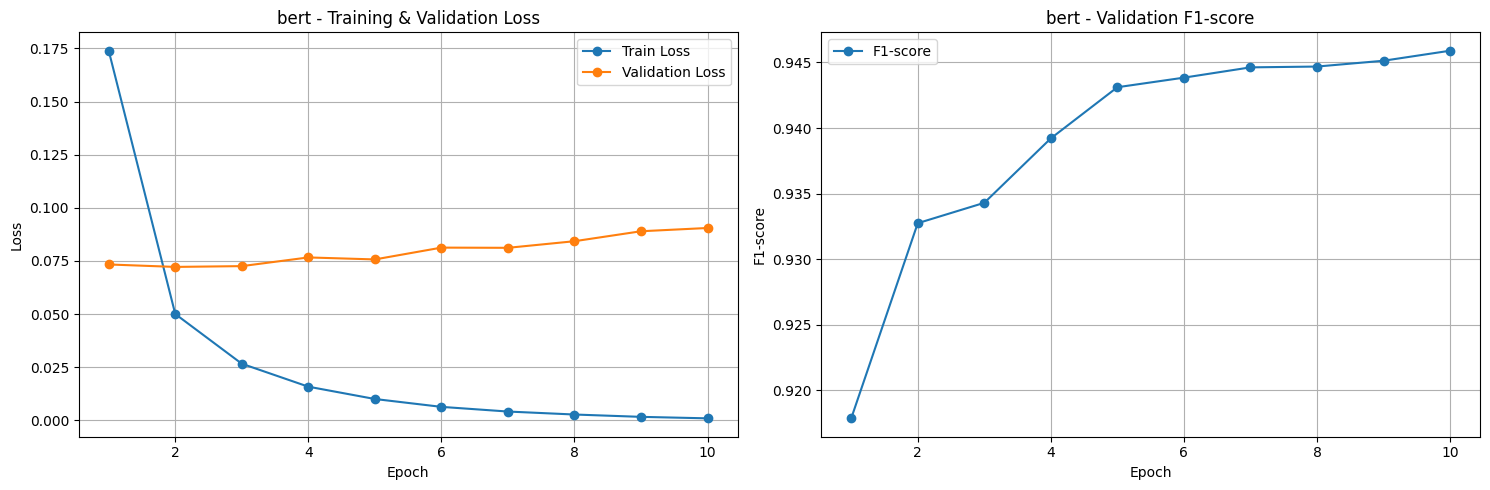

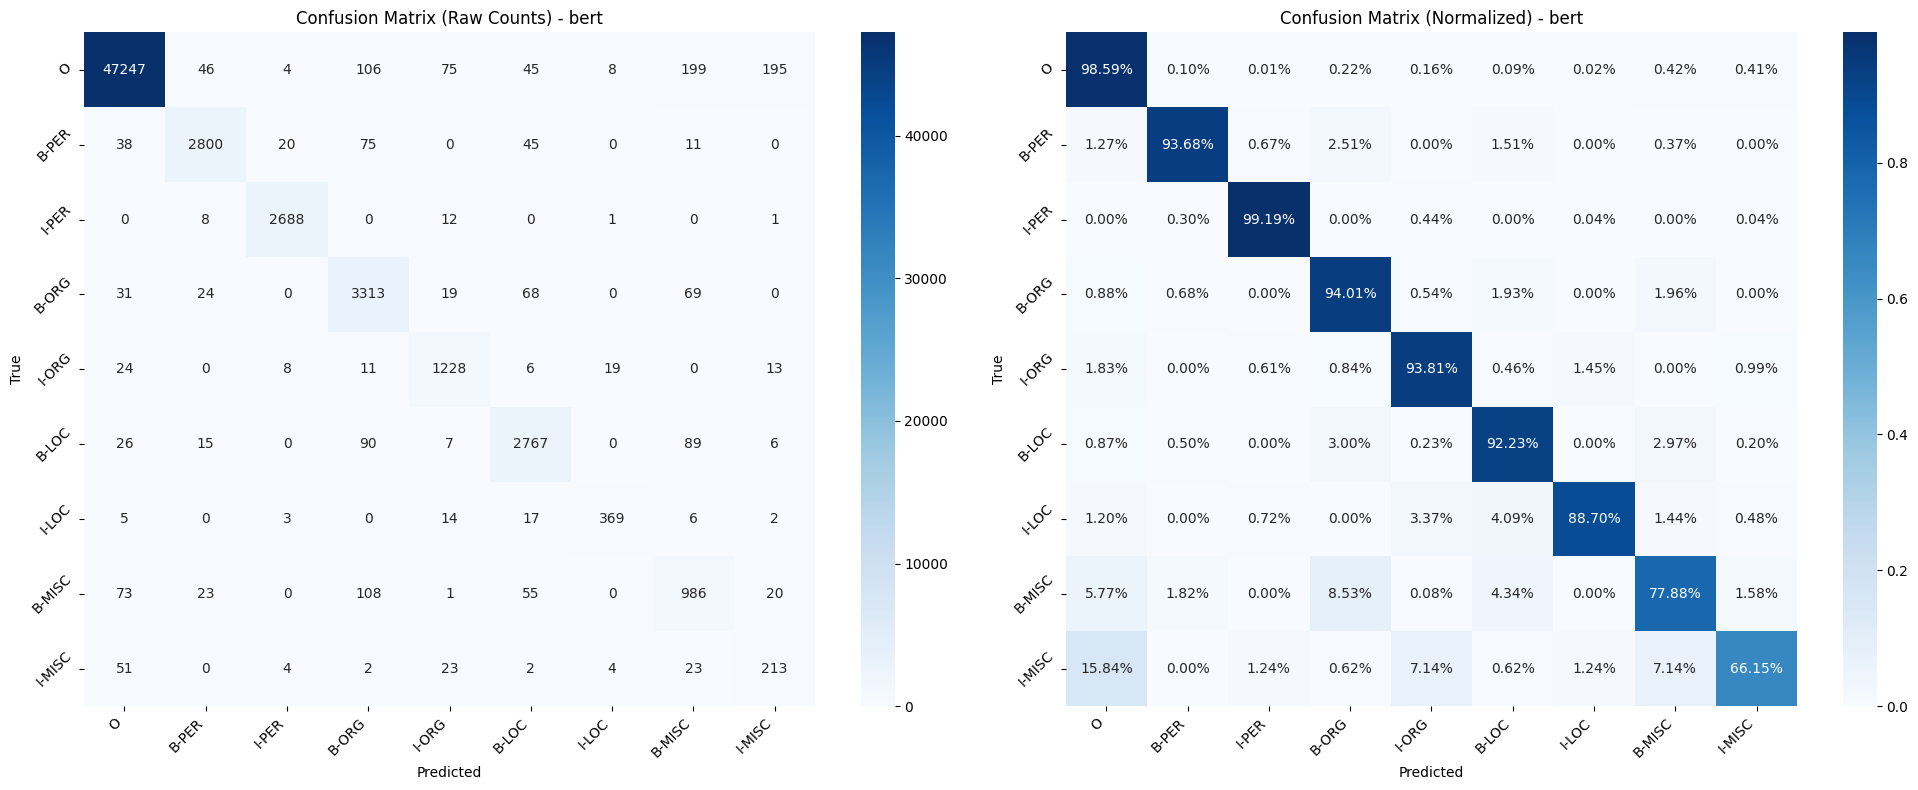


=== Token-level Metrics for bert (Micro-averaged, excluding 'O') ===

Micro-averaged Precision: 0.900
Micro-averaged Recall: 0.925
Micro-averaged F1: 0.912
Overall Accuracy (including 'O'): 0.971

Class Distribution:
        Count  Percentage
O       47925       75.52
B-PER    2989        4.71
I-PER    2710        4.27
B-ORG    3524        5.55
I-ORG    1309        2.06
B-LOC    3000        4.73
I-LOC     416        0.66
B-MISC   1266        1.99
I-MISC    322        0.51


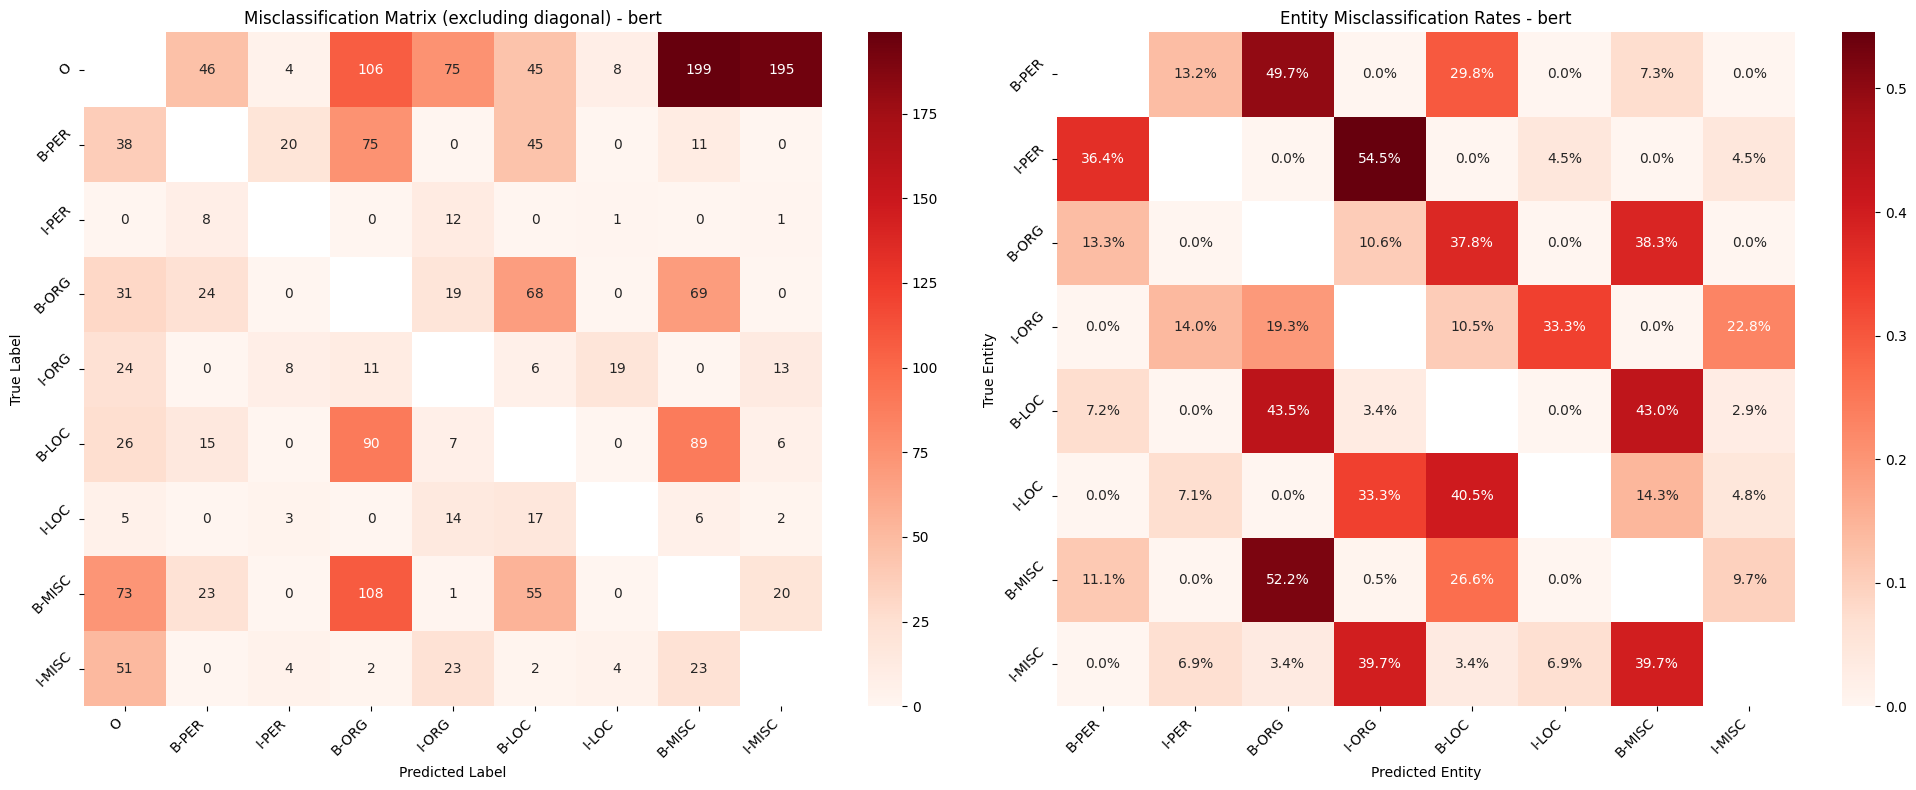


=== Error Analysis for bert ===
Entity  Total  Correct Accuracy Error Rate                                       Top Confusions
 B-PER   2989     2800    93.7%       6.3%     B-ORG: 75 (2.5%), B-LOC: 45 (1.5%), O: 38 (1.3%)
 I-PER   2710     2688    99.2%       0.8%   I-ORG: 12 (0.4%), B-PER: 8 (0.3%), I-LOC: 1 (0.0%)
 B-ORG   3524     3313    94.0%       6.0%    B-MISC: 69 (2.0%), B-LOC: 68 (1.9%), O: 31 (0.9%)
 I-ORG   1309     1228    93.8%       6.2%    O: 24 (1.8%), I-LOC: 19 (1.5%), I-MISC: 13 (1.0%)
 B-LOC   3000     2767    92.2%       7.8%    B-ORG: 90 (3.0%), B-MISC: 89 (3.0%), O: 26 (0.9%)
 I-LOC    416      369    88.7%      11.3% B-LOC: 17 (4.1%), I-ORG: 14 (3.4%), B-MISC: 6 (1.4%)
B-MISC   1266      986    77.9%      22.1%    B-ORG: 108 (8.5%), O: 73 (5.8%), B-LOC: 55 (4.3%)
I-MISC    322      213    66.1%      33.9%   O: 51 (15.8%), I-ORG: 23 (7.1%), B-MISC: 23 (7.1%)



Processing DISTILBERT model...


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy,Detailed Results
1,0.178800,0.091034,0.892729,0.892248,0.892489,0.972994,"{'LOC': {'precision': 0.944, 'recall': 0.914, 'f1': 0.929}, 'MISC': {'precision': 0.742, 'recall': 0.798, 'f1': 0.769}, 'ORG': {'precision': 0.836, 'recall': 0.918, 'f1': 0.875}, 'PER': {'precision': 0.967, 'recall': 0.889, 'f1': 0.926}}"
2,0.058500,0.081266,0.930715,0.918356,0.924494,0.980058,"{'LOC': {'precision': 0.968, 'recall': 0.93, 'f1': 0.949}, 'MISC': {'precision': 0.86, 'recall': 0.832, 'f1': 0.846}, 'ORG': {'precision': 0.915, 'recall': 0.905, 'f1': 0.91}, 'PER': {'precision': 0.934, 'recall': 0.955, 'f1': 0.944}}"
3,0.032600,0.070677,0.926716,0.931455,0.929080,0.982310,"{'LOC': {'precision': 0.966, 'recall': 0.944, 'f1': 0.955}, 'MISC': {'precision': 0.834, 'recall': 0.874, 'f1': 0.854}, 'ORG': {'precision': 0.919, 'recall': 0.907, 'f1': 0.913}, 'PER': {'precision': 0.934, 'recall': 0.963, 'f1': 0.948}}"
4,0.019200,0.085434,0.926175,0.926341,0.926258,0.981618,"{'LOC': {'precision': 0.96, 'recall': 0.954, 'f1': 0.957}, 'MISC': {'precision': 0.834, 'recall': 0.893, 'f1': 0.863}, 'ORG': {'precision': 0.878, 'recall': 0.919, 'f1': 0.898}, 'PER': {'precision': 0.977, 'recall': 0.917, 'f1': 0.946}}"
5,0.011400,0.087719,0.922011,0.937646,0.929763,0.982619,"{'LOC': {'precision': 0.962, 'recall': 0.952, 'f1': 0.957}, 'MISC': {'precision': 0.856, 'recall': 0.884, 'f1': 0.87}, 'ORG': {'precision': 0.882, 'recall': 0.931, 'f1': 0.906}, 'PER': {'precision': 0.943, 'recall': 0.951, 'f1': 0.947}}"
6,0.006800,0.085613,0.927989,0.938812,0.933369,0.983576,"{'LOC': {'precision': 0.958, 'recall': 0.956, 'f1': 0.957}, 'MISC': {'precision': 0.83, 'recall': 0.9, 'f1': 0.864}, 'ORG': {'precision': 0.913, 'recall': 0.916, 'f1': 0.915}, 'PER': {'precision': 0.954, 'recall': 0.956, 'f1': 0.955}}"
7,0.003500,0.103133,0.923774,0.932891,0.928310,0.982531,"{'LOC': {'precision': 0.968, 'recall': 0.943, 'f1': 0.955}, 'MISC': {'precision': 0.859, 'recall': 0.889, 'f1': 0.874}, 'ORG': {'precision': 0.853, 'recall': 0.942, 'f1': 0.895}, 'PER': {'precision': 0.971, 'recall': 0.935, 'f1': 0.953}}"
8,0.002600,0.096817,0.937021,0.943747,0.940372,0.984797,"{'LOC': {'precision': 0.96, 'recall': 0.958, 'f1': 0.959}, 'MISC': {'precision': 0.868, 'recall': 0.893, 'f1': 0.88}, 'ORG': {'precision': 0.918, 'recall': 0.925, 'f1': 0.921}, 'PER': {'precision': 0.959, 'recall': 0.966, 'f1': 0.963}}"
9,0.001600,0.100452,0.937734,0.943119,0.940419,0.984915,"{'LOC': {'precision': 0.97, 'recall': 0.955, 'f1': 0.963}, 'MISC': {'precision': 0.875, 'recall': 0.892, 'f1': 0.884}, 'ORG': {'precision': 0.907, 'recall': 0.923, 'f1': 0.915}, 'PER': {'precision': 0.956, 'recall': 0.969, 'f1': 0.962}}"
10,0.000800,0.100953,0.934999,0.943388,0.939175,0.984562,"{'LOC': {'precision': 0.965, 'recall': 0.959, 'f1': 0.962}, 'MISC': {'precision': 0.862, 'recall': 0.89, 'f1': 0.876}, 'ORG': {'precision': 0.905, 'recall': 0.928, 'f1': 0.917}, 'PER': {'precision': 0.96, 'recall': 0.962, 'f1': 0.961}}"


Training completed. Best metric: 0.9404186795491144


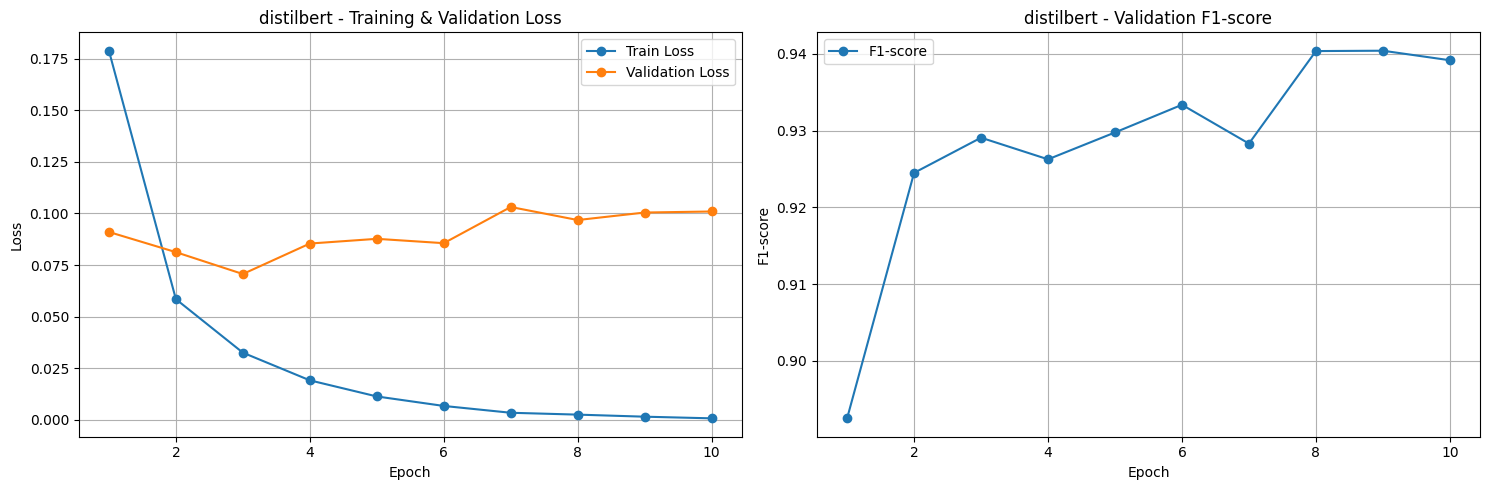

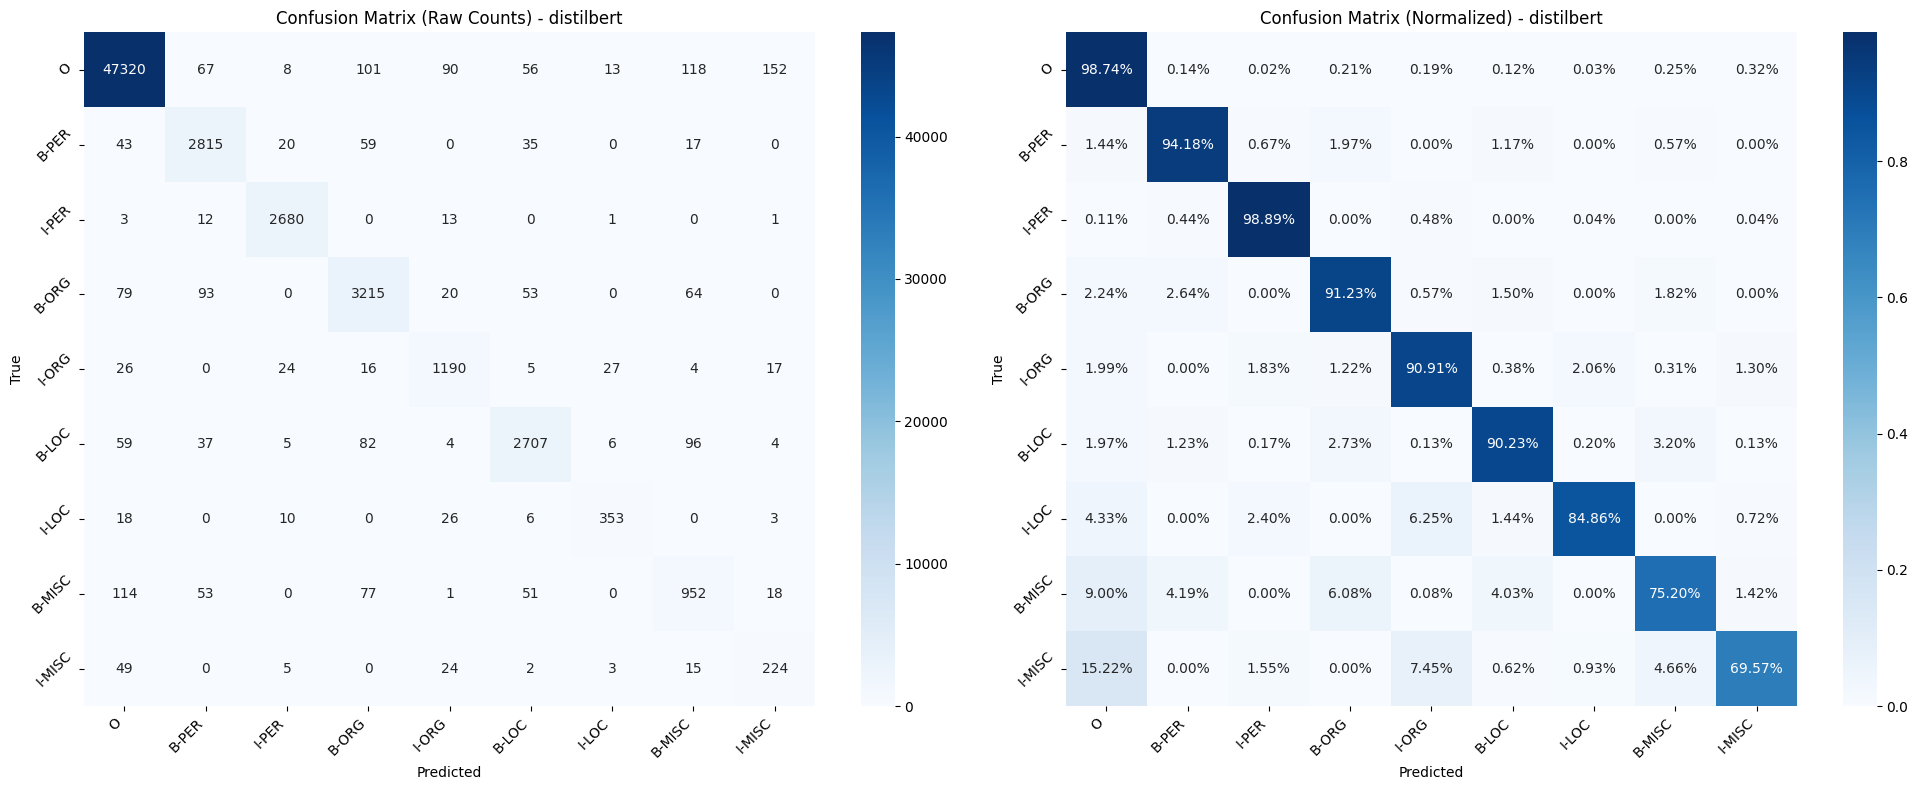


=== Token-level Metrics for distilbert (Micro-averaged, excluding 'O') ===

Micro-averaged Precision: 0.898
Micro-averaged Recall: 0.910
Micro-averaged F1: 0.904
Overall Accuracy (including 'O'): 0.968

Class Distribution:
        Count  Percentage
O       47925       75.52
B-PER    2989        4.71
I-PER    2710        4.27
B-ORG    3524        5.55
I-ORG    1309        2.06
B-LOC    3000        4.73
I-LOC     416        0.66
B-MISC   1266        1.99
I-MISC    322        0.51


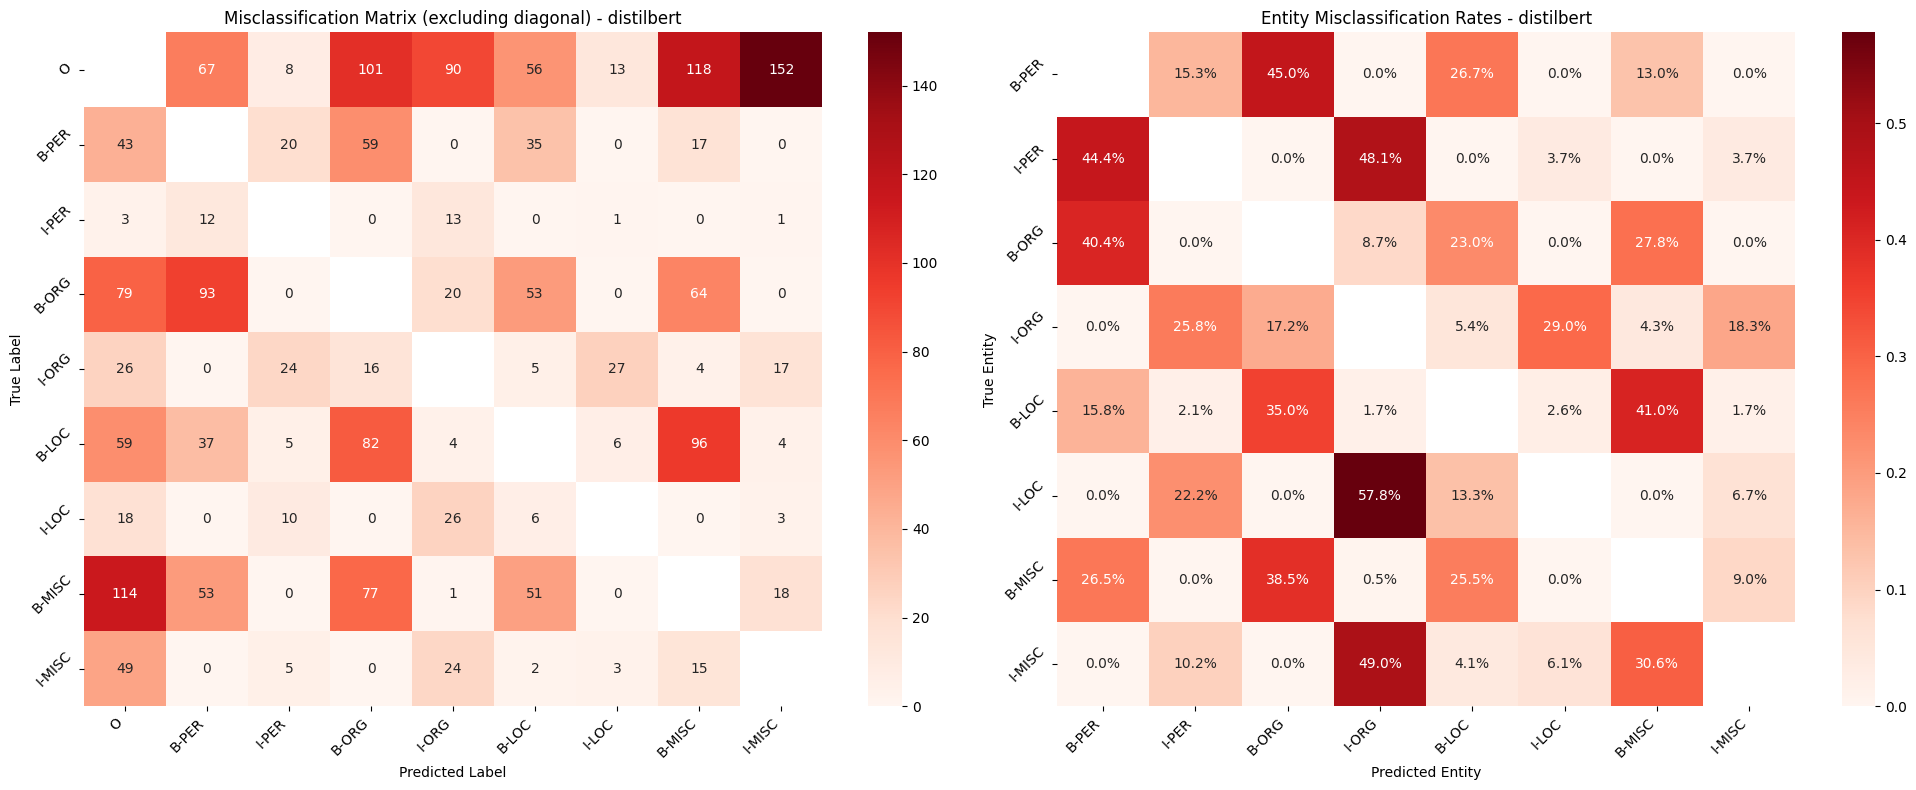


=== Error Analysis for distilbert ===
Entity  Total  Correct Accuracy Error Rate                                     Top Confusions
 B-PER   2989     2815    94.2%       5.8%   B-ORG: 59 (2.0%), O: 43 (1.4%), B-LOC: 35 (1.2%)
 I-PER   2710     2680    98.9%       1.1%    I-ORG: 13 (0.5%), B-PER: 12 (0.4%), O: 3 (0.1%)
 B-ORG   3524     3215    91.2%       8.8%  B-PER: 93 (2.6%), O: 79 (2.2%), B-MISC: 64 (1.8%)
 I-ORG   1309     1190    90.9%       9.1%   I-LOC: 27 (2.1%), O: 26 (2.0%), I-PER: 24 (1.8%)
 B-LOC   3000     2707    90.2%       9.8%  B-MISC: 96 (3.2%), B-ORG: 82 (2.7%), O: 59 (2.0%)
 I-LOC    416      353    84.9%      15.1%   I-ORG: 26 (6.2%), O: 18 (4.3%), I-PER: 10 (2.4%)
B-MISC   1266      952    75.2%      24.8%  O: 114 (9.0%), B-ORG: 77 (6.1%), B-PER: 53 (4.2%)
I-MISC    322      224    69.6%      30.4% O: 49 (15.2%), I-ORG: 24 (7.5%), B-MISC: 15 (4.7%)



Processing ALBERT model...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForTokenClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy,Detailed Results
1,0.136400,0.093039,0.855325,0.862515,0.858905,0.971626,"{'LOC': {'precision': 0.924, 'recall': 0.957, 'f1': 0.94}, 'MISC': {'precision': 0.848, 'recall': 0.752, 'f1': 0.797}, 'ORG': {'precision': 0.681, 'recall': 0.916, 'f1': 0.781}, 'PER': {'precision': 0.98, 'recall': 0.791, 'f1': 0.876}}"
2,0.057000,0.063351,0.922967,0.926336,0.924648,0.983748,"{'LOC': {'precision': 0.941, 'recall': 0.957, 'f1': 0.949}, 'MISC': {'precision': 0.845, 'recall': 0.832, 'f1': 0.839}, 'ORG': {'precision': 0.873, 'recall': 0.898, 'f1': 0.885}, 'PER': {'precision': 0.974, 'recall': 0.957, 'f1': 0.965}}"
3,0.037100,0.067837,0.920659,0.933083,0.926829,0.983434,"{'LOC': {'precision': 0.953, 'recall': 0.954, 'f1': 0.953}, 'MISC': {'precision': 0.864, 'recall': 0.827, 'f1': 0.845}, 'ORG': {'precision': 0.846, 'recall': 0.92, 'f1': 0.882}, 'PER': {'precision': 0.97, 'recall': 0.966, 'f1': 0.968}}"
4,0.024500,0.071787,0.930618,0.937618,0.934105,0.985158,"{'LOC': {'precision': 0.956, 'recall': 0.96, 'f1': 0.958}, 'MISC': {'precision': 0.842, 'recall': 0.844, 'f1': 0.843}, 'ORG': {'precision': 0.902, 'recall': 0.905, 'f1': 0.903}, 'PER': {'precision': 0.964, 'recall': 0.978, 'f1': 0.971}}"
5,0.015200,0.070880,0.933209,0.938060,0.935628,0.985201,"{'LOC': {'precision': 0.953, 'recall': 0.959, 'f1': 0.956}, 'MISC': {'precision': 0.861, 'recall': 0.864, 'f1': 0.863}, 'ORG': {'precision': 0.895, 'recall': 0.91, 'f1': 0.903}, 'PER': {'precision': 0.972, 'recall': 0.969, 'f1': 0.97}}"
6,0.009400,0.084361,0.935144,0.932972,0.934057,0.984403,"{'LOC': {'precision': 0.939, 'recall': 0.969, 'f1': 0.954}, 'MISC': {'precision': 0.833, 'recall': 0.868, 'f1': 0.85}, 'ORG': {'precision': 0.929, 'recall': 0.87, 'f1': 0.899}, 'PER': {'precision': 0.979, 'recall': 0.971, 'f1': 0.975}}"
7,0.005900,0.078985,0.936117,0.944918,0.940497,0.985642,"{'LOC': {'precision': 0.958, 'recall': 0.958, 'f1': 0.958}, 'MISC': {'precision': 0.849, 'recall': 0.872, 'f1': 0.86}, 'ORG': {'precision': 0.91, 'recall': 0.917, 'f1': 0.914}, 'PER': {'precision': 0.971, 'recall': 0.982, 'f1': 0.976}}"
8,0.004000,0.084990,0.932350,0.943590,0.937936,0.985357,"{'LOC': {'precision': 0.952, 'recall': 0.966, 'f1': 0.959}, 'MISC': {'precision': 0.832, 'recall': 0.874, 'f1': 0.852}, 'ORG': {'precision': 0.91, 'recall': 0.911, 'f1': 0.91}, 'PER': {'precision': 0.973, 'recall': 0.975, 'f1': 0.974}}"
9,0.002100,0.092632,0.934866,0.944586,0.939701,0.985685,"{'LOC': {'precision': 0.956, 'recall': 0.964, 'f1': 0.96}, 'MISC': {'precision': 0.836, 'recall': 0.882, 'f1': 0.858}, 'ORG': {'precision': 0.911, 'recall': 0.91, 'f1': 0.911}, 'PER': {'precision': 0.975, 'recall': 0.977, 'f1': 0.976}}"
10,0.001400,0.092693,0.935604,0.944918,0.940238,0.985813,"{'LOC': {'precision': 0.952, 'recall': 0.965, 'f1': 0.958}, 'MISC': {'precision': 0.843, 'recall': 0.88, 'f1': 0.861}, 'ORG': {'precision': 0.916, 'recall': 0.91, 'f1': 0.913}, 'PER': {'precision': 0.974, 'recall': 0.978, 'f1': 0.976}}"


Training completed. Best metric: 0.9404965046512909


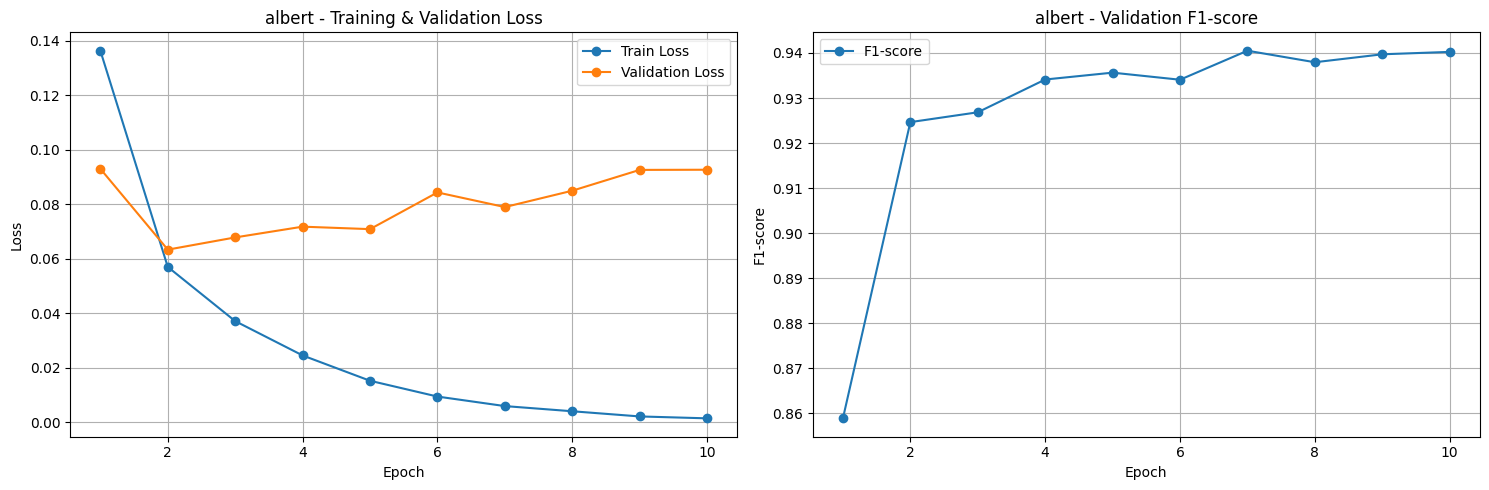

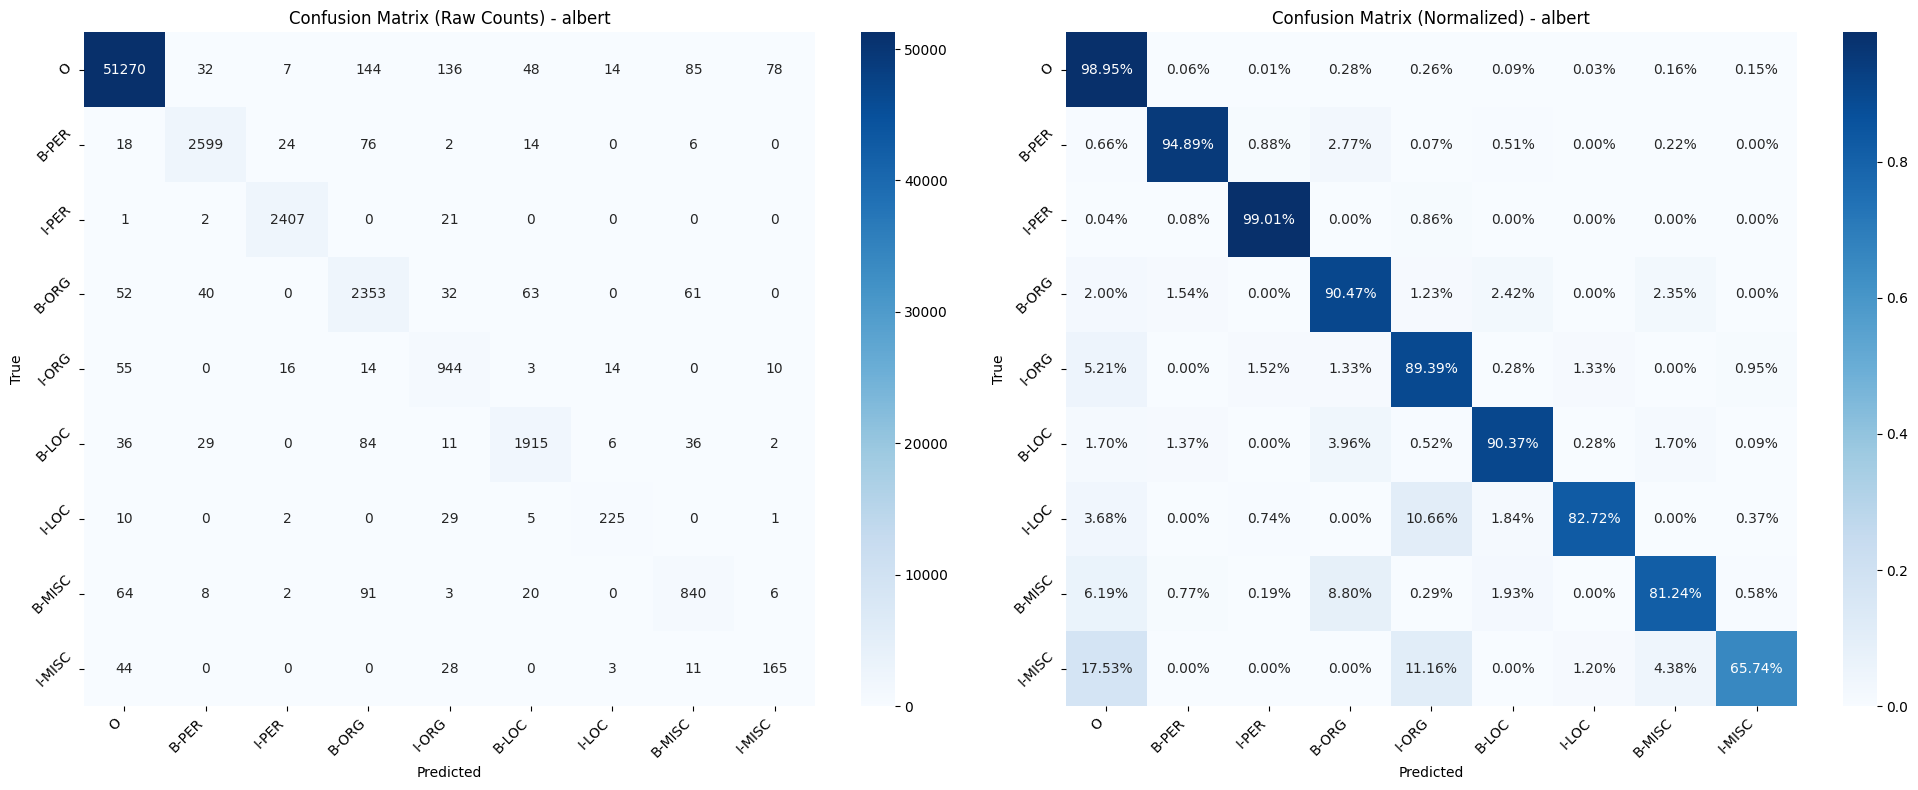


=== Token-level Metrics for albert (Micro-averaged, excluding 'O') ===

Micro-averaged Precision: 0.897
Micro-averaged Recall: 0.916
Micro-averaged F1: 0.906
Overall Accuracy (including 'O'): 0.975

Class Distribution:
        Count  Percentage
O       51814       80.56
B-PER    2739        4.26
I-PER    2431        3.78
B-ORG    2601        4.04
I-ORG    1056        1.64
B-LOC    2119        3.29
I-LOC     272        0.42
B-MISC   1034        1.61
I-MISC    251        0.39


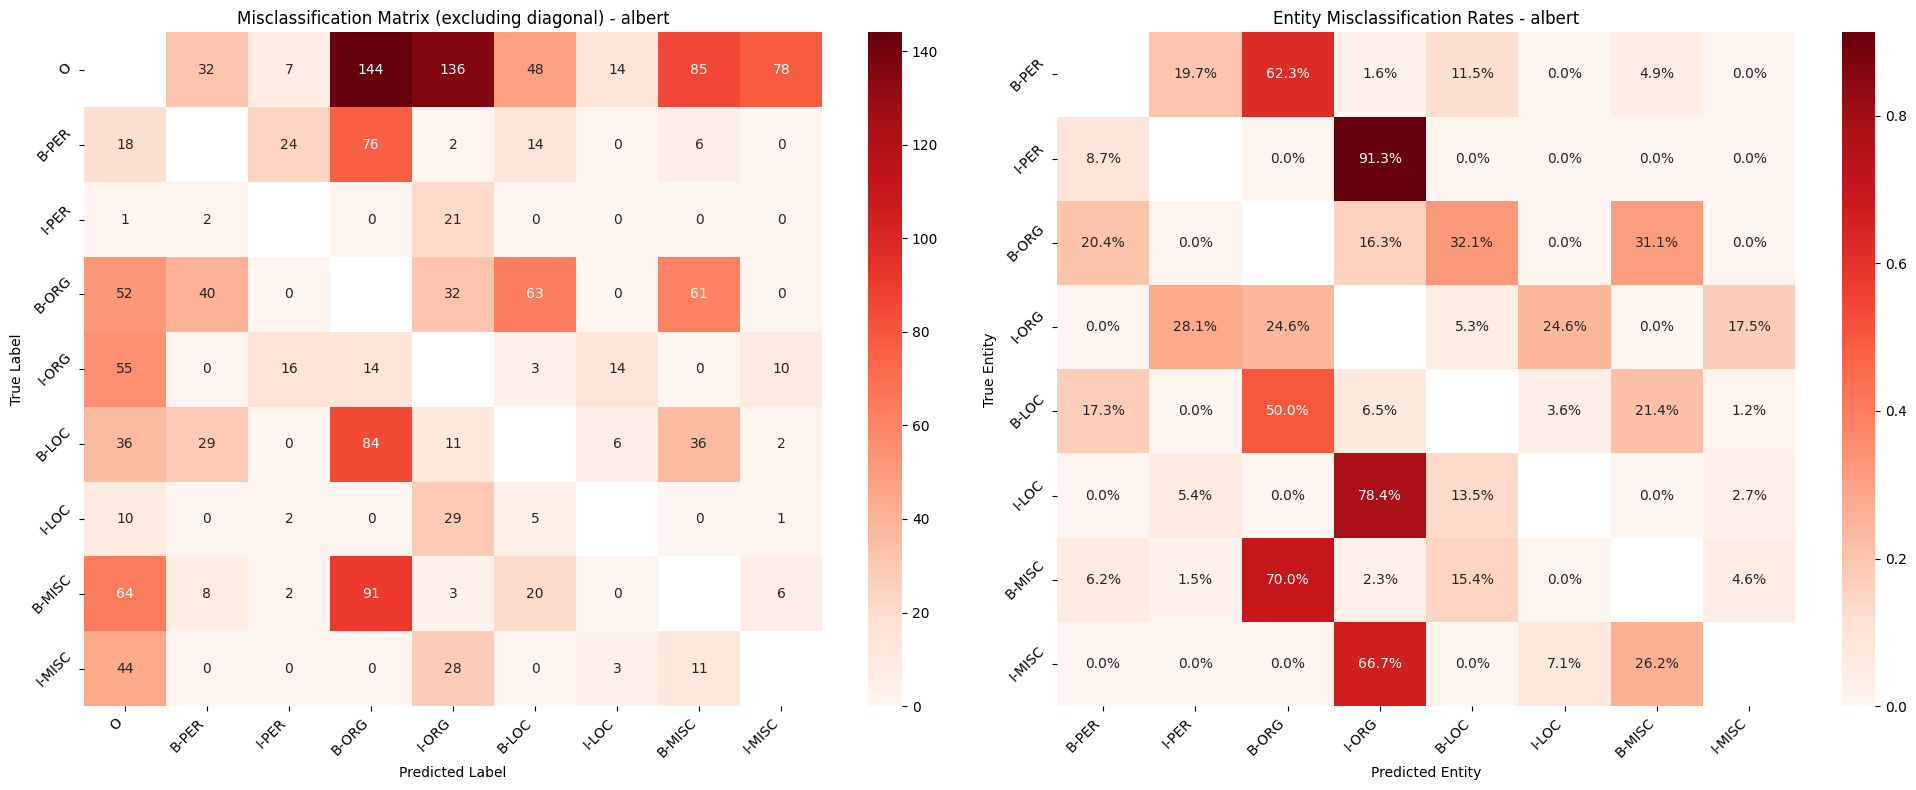


=== Error Analysis for albert ===
Entity  Total  Correct Accuracy Error Rate                                      Top Confusions
 B-PER   2739     2599    94.9%       5.1%    B-ORG: 76 (2.8%), I-PER: 24 (0.9%), O: 18 (0.7%)
 I-PER   2431     2407    99.0%       1.0%      I-ORG: 21 (0.9%), B-PER: 2 (0.1%), O: 1 (0.0%)
 B-ORG   2601     2353    90.5%       9.5%   B-LOC: 63 (2.4%), B-MISC: 61 (2.3%), O: 52 (2.0%)
 I-ORG   1056      944    89.4%      10.6%    O: 55 (5.2%), I-PER: 16 (1.5%), B-ORG: 14 (1.3%)
 B-LOC   2119     1915    90.4%       9.6%   B-ORG: 84 (4.0%), O: 36 (1.7%), B-MISC: 36 (1.7%)
 I-LOC    272      225    82.7%      17.3%    I-ORG: 29 (10.7%), O: 10 (3.7%), B-LOC: 5 (1.8%)
B-MISC   1034      840    81.2%      18.8%    B-ORG: 91 (8.8%), O: 64 (6.2%), B-LOC: 20 (1.9%)
I-MISC    251      165    65.7%      34.3% O: 44 (17.5%), I-ORG: 28 (11.2%), B-MISC: 11 (4.4%)



Processing DEBERTA model...


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForTokenClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy,Detailed Results
1,0.123500,0.060053,0.923058,0.935905,0.929437,0.985525,"{'LOC': {'precision': 0.96, 'recall': 0.964, 'f1': 0.962}, 'MISC': {'precision': 0.881, 'recall': 0.82, 'f1': 0.85}, 'ORG': {'precision': 0.829, 'recall': 0.955, 'f1': 0.888}, 'PER': {'precision': 0.98, 'recall': 0.945, 'f1': 0.962}}"
2,0.033100,0.051561,0.942878,0.951166,0.947004,0.989259,"{'LOC': {'precision': 0.975, 'recall': 0.973, 'f1': 0.974}, 'MISC': {'precision': 0.881, 'recall': 0.869, 'f1': 0.875}, 'ORG': {'precision': 0.943, 'recall': 0.916, 'f1': 0.929}, 'PER': {'precision': 0.937, 'recall': 0.988, 'f1': 0.962}}"
3,0.019900,0.038308,0.958495,0.964229,0.961354,0.991710,"{'LOC': {'precision': 0.975, 'recall': 0.983, 'f1': 0.979}, 'MISC': {'precision': 0.912, 'recall': 0.89, 'f1': 0.901}, 'ORG': {'precision': 0.948, 'recall': 0.943, 'f1': 0.946}, 'PER': {'precision': 0.968, 'recall': 0.992, 'f1': 0.98}}"
4,0.012100,0.044055,0.955829,0.958979,0.957401,0.990871,"{'LOC': {'precision': 0.978, 'recall': 0.974, 'f1': 0.976}, 'MISC': {'precision': 0.886, 'recall': 0.893, 'f1': 0.89}, 'ORG': {'precision': 0.928, 'recall': 0.944, 'f1': 0.936}, 'PER': {'precision': 0.983, 'recall': 0.982, 'f1': 0.983}}"
5,0.009000,0.046842,0.956253,0.963374,0.959801,0.991331,"{'LOC': {'precision': 0.979, 'recall': 0.979, 'f1': 0.979}, 'MISC': {'precision': 0.895, 'recall': 0.893, 'f1': 0.894}, 'ORG': {'precision': 0.934, 'recall': 0.957, 'f1': 0.945}, 'PER': {'precision': 0.976, 'recall': 0.983, 'f1': 0.979}}"
6,0.006100,0.043270,0.962576,0.967159,0.964862,0.992466,"{'LOC': {'precision': 0.982, 'recall': 0.979, 'f1': 0.98}, 'MISC': {'precision': 0.907, 'recall': 0.918, 'f1': 0.913}, 'ORG': {'precision': 0.952, 'recall': 0.948, 'f1': 0.95}, 'PER': {'precision': 0.975, 'recall': 0.99, 'f1': 0.982}}"
7,0.003700,0.047580,0.962264,0.965084,0.963672,0.991792,"{'LOC': {'precision': 0.983, 'recall': 0.98, 'f1': 0.982}, 'MISC': {'precision': 0.91, 'recall': 0.904, 'f1': 0.907}, 'ORG': {'precision': 0.939, 'recall': 0.956, 'f1': 0.947}, 'PER': {'precision': 0.98, 'recall': 0.983, 'f1': 0.981}}"
8,0.002800,0.049793,0.955781,0.965816,0.960772,0.991611,"{'LOC': {'precision': 0.974, 'recall': 0.981, 'f1': 0.978}, 'MISC': {'precision': 0.893, 'recall': 0.917, 'f1': 0.905}, 'ORG': {'precision': 0.939, 'recall': 0.95, 'f1': 0.945}, 'PER': {'precision': 0.977, 'recall': 0.982, 'f1': 0.979}}"
9,0.002300,0.049247,0.962495,0.968136,0.965307,0.992318,"{'LOC': {'precision': 0.979, 'recall': 0.982, 'f1': 0.981}, 'MISC': {'precision': 0.913, 'recall': 0.91, 'f1': 0.912}, 'ORG': {'precision': 0.942, 'recall': 0.958, 'f1': 0.95}, 'PER': {'precision': 0.981, 'recall': 0.986, 'f1': 0.984}}"
10,0.001500,0.050478,0.961315,0.967770,0.964531,0.992417,"{'LOC': {'precision': 0.98, 'recall': 0.98, 'f1': 0.98}, 'MISC': {'precision': 0.909, 'recall': 0.913, 'f1': 0.911}, 'ORG': {'precision': 0.94, 'recall': 0.957, 'f1': 0.948}, 'PER': {'precision': 0.98, 'recall': 0.987, 'f1': 0.984}}"


Training completed. Best metric: 0.9653073645769933


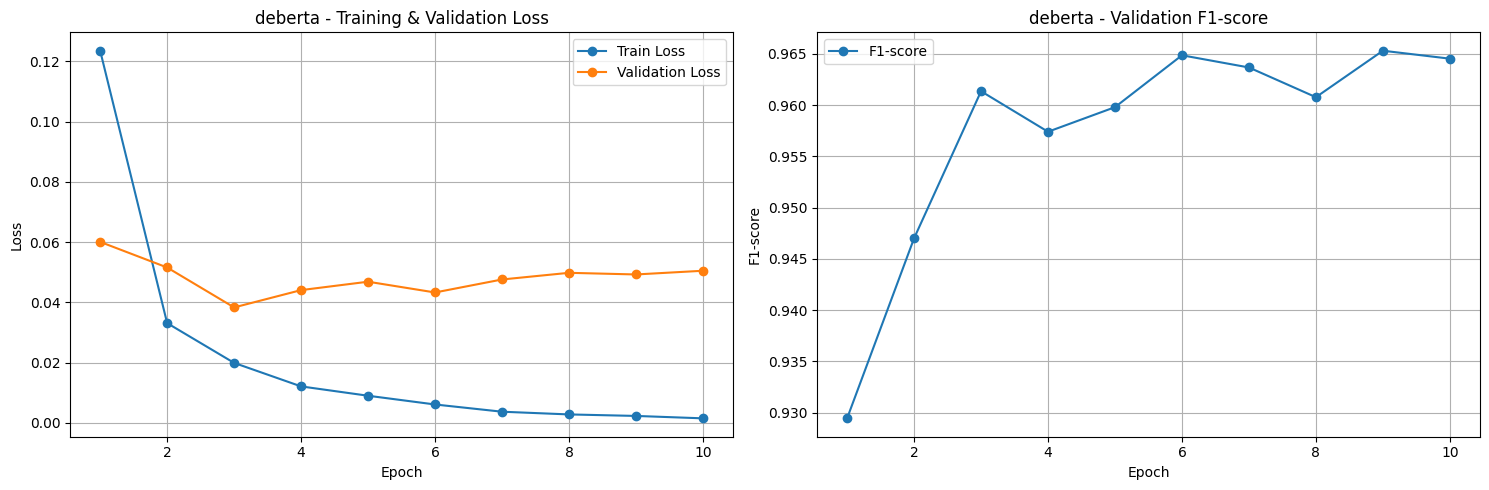

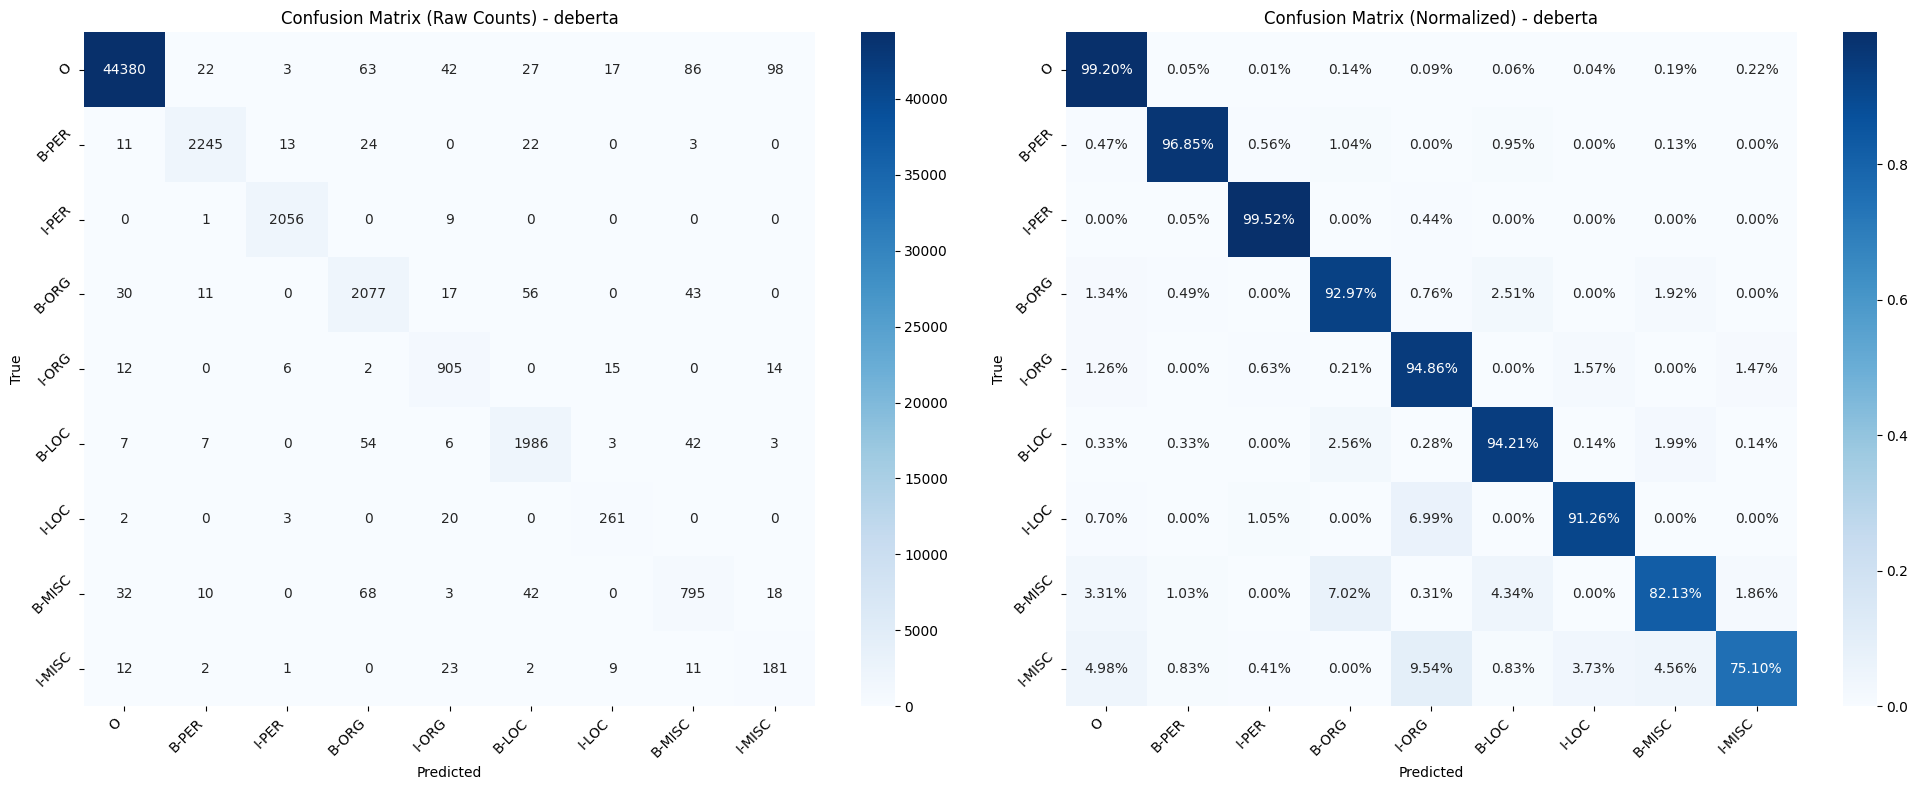


=== Token-level Metrics for deberta (Micro-averaged, excluding 'O') ===

Micro-averaged Precision: 0.919
Micro-averaged Recall: 0.940
Micro-averaged F1: 0.930
Overall Accuracy (including 'O'): 0.982

Class Distribution:
        Count  Percentage
O       44738       80.01
B-PER    2318        4.15
I-PER    2066        3.70
B-ORG    2234        4.00
I-ORG     954        1.71
B-LOC    2108        3.77
I-LOC     286        0.51
B-MISC    968        1.73
I-MISC    241        0.43


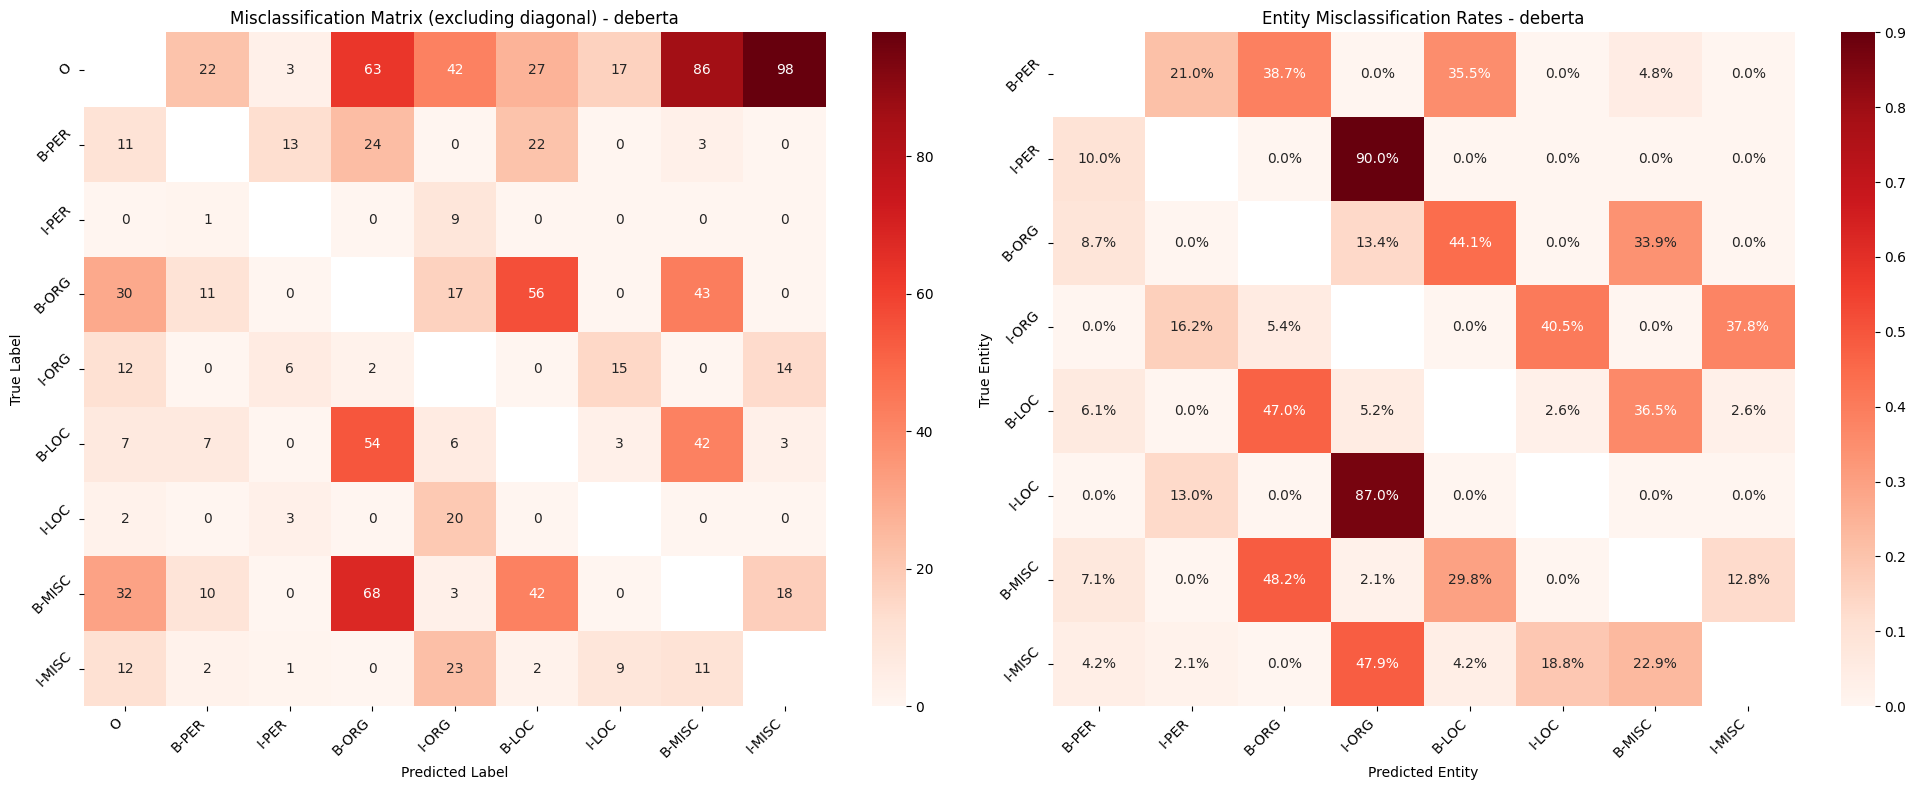


=== Error Analysis for deberta ===
Entity  Total  Correct Accuracy Error Rate                                       Top Confusions
 B-PER   2318     2245    96.9%       3.1% B-ORG: 24 (1.0%), B-LOC: 22 (0.9%), I-PER: 13 (0.6%)
 I-PER   2066     2056    99.5%       0.5%                     I-ORG: 9 (0.4%), B-PER: 1 (0.0%)
 B-ORG   2234     2077    93.0%       7.0%    B-LOC: 56 (2.5%), B-MISC: 43 (1.9%), O: 30 (1.3%)
 I-ORG    954      905    94.9%       5.1%    I-LOC: 15 (1.6%), I-MISC: 14 (1.5%), O: 12 (1.3%)
 B-LOC   2108     1986    94.2%       5.8%     B-ORG: 54 (2.6%), B-MISC: 42 (2.0%), O: 7 (0.3%)
 I-LOC    286      261    91.3%       8.7%       I-ORG: 20 (7.0%), I-PER: 3 (1.0%), O: 2 (0.7%)
B-MISC    968      795    82.1%      17.9%     B-ORG: 68 (7.0%), B-LOC: 42 (4.3%), O: 32 (3.3%)
I-MISC    241      181    75.1%      24.9%    I-ORG: 23 (9.5%), O: 12 (5.0%), B-MISC: 11 (4.6%)


In [ ]:
# Initialize result dictionaries
results_dict = {}
token_results_dict = {}  
timing_dict = {}  #  for storing timing metrics

# Train and evaluate each model
for model_type, config in MODEL_CONFIGS.items():
    try:
        print(f"\n\n\nProcessing {model_type.upper()} model...")
        
        #  Initialize timing
        start_time = time.time()
        
        # Initialize tokenizer and preprocess data
        tokenizer = AutoTokenizer.from_pretrained(
            config['name'],
            # # Use slow tokenizer for ALBERT
            # use_fast=False if 'albert' in config['name'].lower() else True
        )  
        
        # Set appropriate max lengths
        if 'deberta' in config['name']:
            tokenizer.model_max_length = 128
        elif 'albert' in config['name']:
            tokenizer.model_max_length = 128
        
        # Tokenize datasets
        tokenized_datasets = datasets.map(
            lambda x: tokenize_and_align_labels(x, tokenizer),
            batched=True,
            remove_columns=datasets["train"].column_names
        )
        
        # Prepare and train model
        trainer = prepare_model_and_trainer(config, len(label_list), tokenized_datasets, tokenizer)
        
        #  Get model parameter count
        num_params = get_model_parameters(trainer.model)
        
        #  Training start time
        train_start_time = time.time()
        
        # Train with error handling
        try:
            train_result = trainer.train()
            print(f"Training completed. Best metric: {trainer.state.best_metric}")
            
            # Get actual number of epochs trained (can be decimal due to early stopping)
            actual_epochs = trainer.state.epoch
            
            #  Training end time
            train_end_time = time.time()
            train_duration = train_end_time - train_start_time
            
        except Exception as e:
            print(f"Training error for {model_type}: {str(e)}")
            continue
            
        # Plot training curves
        plot_training_curves(trainer, model_type)
        
        # Evaluation start time
        eval_start_time = time.time()
        
        # Evaluate on test set
        try:
            predictions, labels, _ = trainer.predict(tokenized_datasets["test"])
            test_metrics = compute_metrics((predictions, labels))
            
            #  Evaluation end time
            eval_end_time = time.time()
            eval_duration = eval_end_time - eval_start_time
            
            # Store entity-level results
            results_dict[model_type] = {
                'eval_detailed_results': test_metrics['detailed_results'],
                'overall_metrics': {
                    'precision': test_metrics['precision'],
                    'recall': test_metrics['recall'],
                    'f1': test_metrics['f1'],
                    'accuracy': test_metrics['accuracy']
                }
            }
            
            # Calculate and store token-level metrics
            predictions_argmax = np.argmax(predictions, axis=2)
            token_metrics = plot_confusion_matrix_with_token_metrics(labels, predictions_argmax, label_list, model_type)
            token_results_dict[model_type] = token_metrics
    
            # Generate misclassification heatmap
            plot_misclassification_heatmap(labels, predictions_argmax, label_list, model_type)
            
        except Exception as e:
            print(f"Evaluation error for {model_type}: {str(e)}")
            continue
        
        #  Total end time
        end_time = time.time()
        total_duration = end_time - start_time
        
        #  Store timing information
        timing_dict[model_type] = {
            'total_runtime': total_duration,
            'train_runtime': train_duration,
            'eval_runtime': eval_duration,
            'actual_epochs': actual_epochs,
            'avg_epoch_time': train_duration / actual_epochs if actual_epochs > 0 else 0,
            'parameters': num_params,
            'model_config': config
        }
            
        # Clean up GPU memory
        del trainer
        del predictions
        del labels
        torch.cuda.empty_cache()
        
    except Exception as e:
        print(f"Error processing {model_type}: {str(e)}")
        continue

## 6. Performance Analysis and Visualization

### 6.1 Plot Entity Performance

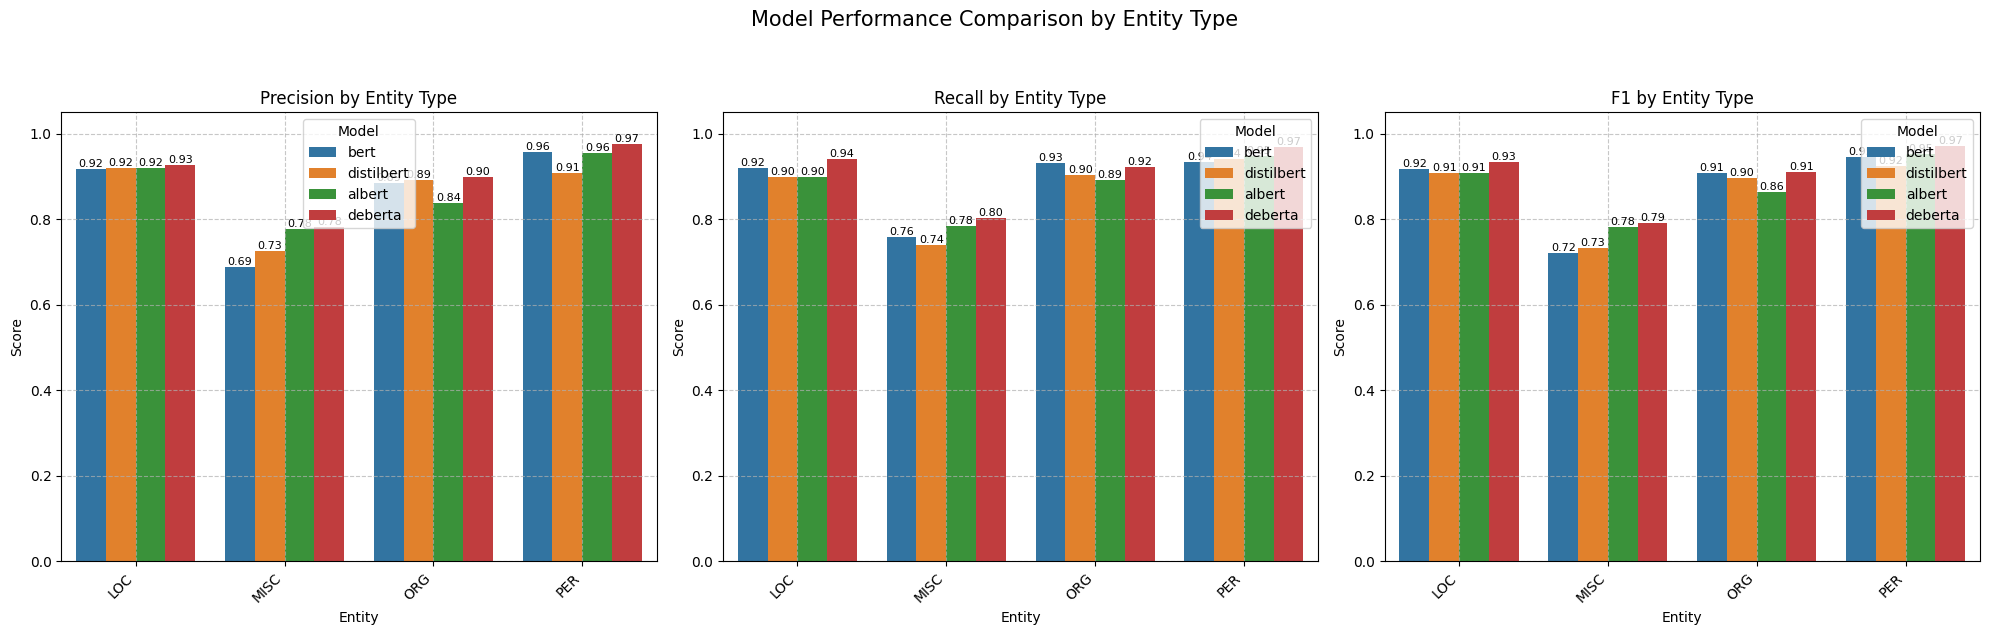

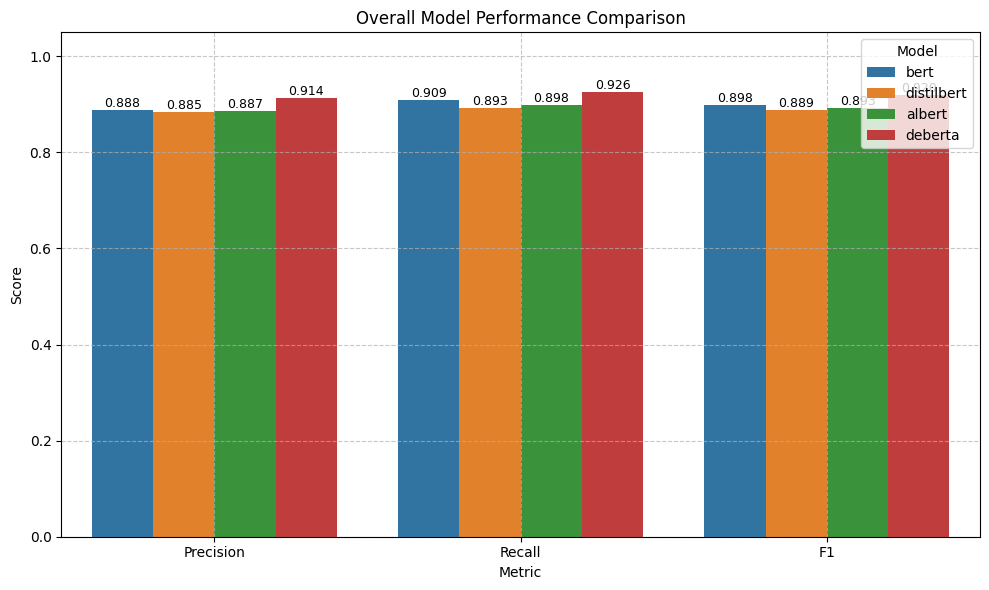


=== Detailed Entity-Type Performance by Model ===

Detailed Metrics by Entity Type:
Entity      Model Precision Recall    F1
   LOC       bert     0.917  0.919 0.918
   LOC distilbert     0.921  0.898 0.909
   LOC     albert     0.919  0.899 0.909
   LOC    deberta     0.927  0.941 0.934
  MISC       bert     0.688  0.758 0.721
  MISC distilbert     0.726  0.739 0.732
  MISC     albert     0.778  0.784 0.781
  MISC    deberta     0.781  0.802 0.791
   ORG       bert     0.885  0.932 0.908
   ORG distilbert     0.891  0.903 0.897
   ORG     albert     0.837  0.891 0.863
   ORG    deberta     0.898  0.922 0.910
   PER       bert     0.957  0.935 0.946
   PER distilbert     0.909  0.940 0.924
   PER     albert     0.956  0.947 0.952
   PER    deberta     0.975  0.968 0.971

=== Overall Model Performance ===

Overall Metrics:
     Model Precision Recall    F1 Accuracy
      bert     0.888  0.909 0.898    0.971
distilbert     0.885  0.893 0.889    0.968
    albert     0.887  0.898 0.893   

In [18]:
# Compare entity type performance across models
plot_entity_performance(results_dict, list(MODEL_CONFIGS.keys()))


### 6.2 Compare Token and Entity Metrics

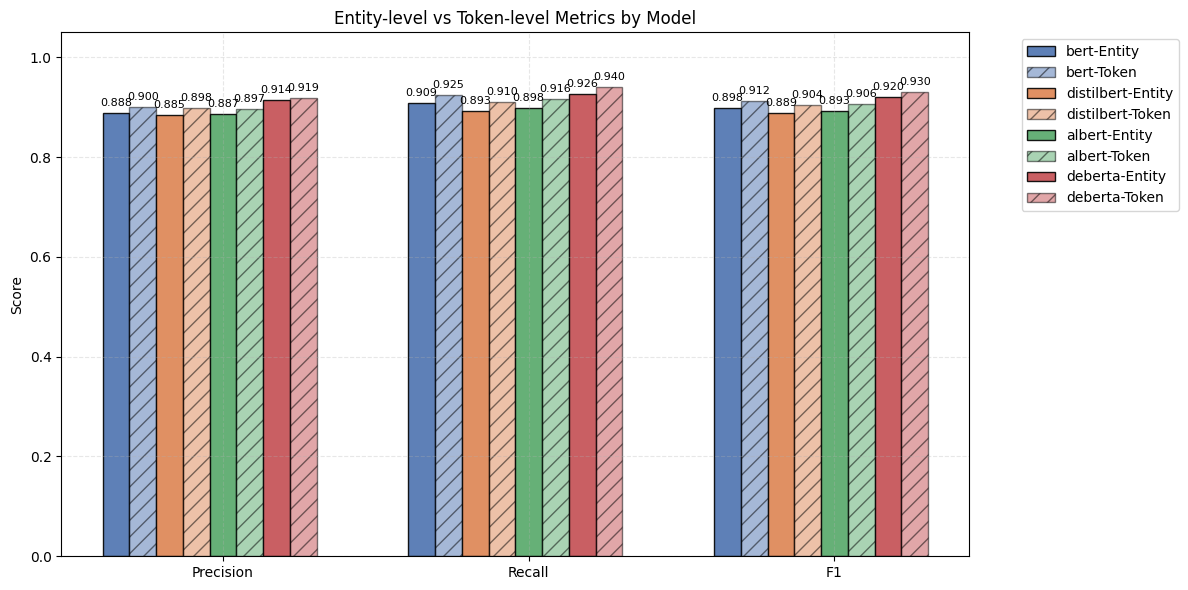

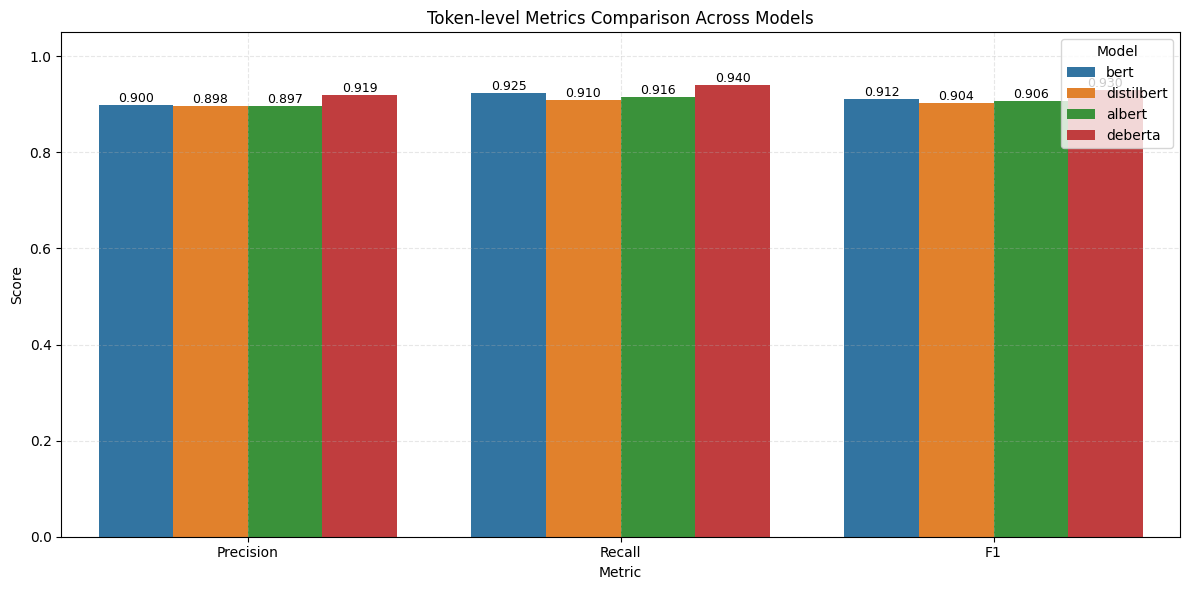


=== Detailed Metrics Comparison ===

Entity-level Metrics:
Metric         F1  Precision  Recall
Model                               
albert      0.893      0.887   0.898
bert        0.898      0.888   0.909
deberta     0.920      0.914   0.926
distilbert  0.889      0.885   0.893

Token-level Metrics:
Metric         F1  Precision  Recall
Model                               
albert      0.906      0.897   0.916
bert        0.912      0.900   0.925
deberta     0.930      0.919   0.940
distilbert  0.904      0.898   0.910

=== Token vs Entity Level Differences ===

Token minus Entity level metrics (positive means token-level is higher):
Metric      Precision  Recall     F1
bert            0.012   0.016  0.014
distilbert      0.013   0.017  0.015
albert          0.010   0.017  0.013
deberta         0.005   0.014  0.010


{'Entity': Metric         F1  Precision  Recall
 Model                               
 albert      0.893      0.887   0.898
 bert        0.898      0.888   0.909
 deberta     0.920      0.914   0.926
 distilbert  0.889      0.885   0.893,
 'Token': Metric         F1  Precision  Recall
 Model                               
 albert      0.906      0.897   0.916
 bert        0.912      0.900   0.925
 deberta     0.930      0.919   0.940
 distilbert  0.904      0.898   0.910}

In [19]:
# Compare token-level and entity-level metrics
compare_token_and_entity_metrics(results_dict, token_results_dict)

### 6.3 Compare Model Efficiency


=== Model Efficiency Comparison ===
     Model Total Runtime (sec) Training Time (sec) Evaluation Time (sec) Actual Epochs Avg Time per Epoch (sec) Parameters (millions) F1 Score
      bert             1009.70              991.96                  8.19          10.0                    99.20                107.73    0.898
distilbert              554.50              541.04                  5.95          10.0                    54.10                 65.20    0.889
    albert              968.47              952.08                  8.93          10.0                    95.21                 11.10    0.893
   deberta             1432.89             1412.55                 10.16          10.0                   141.25                183.84    0.920


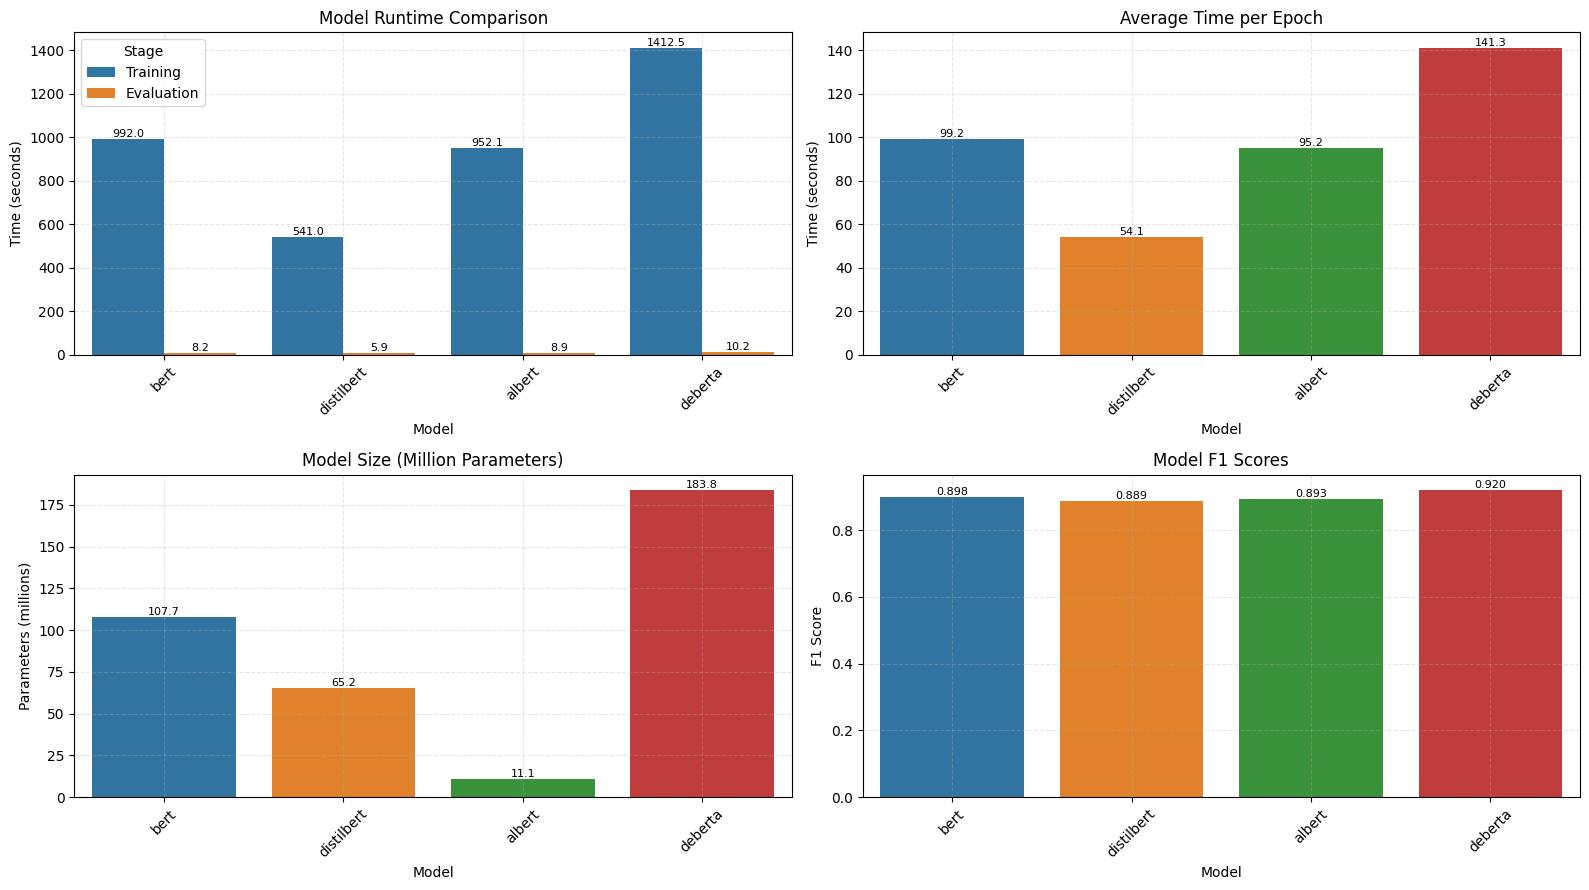

,Model,Total Runtime (sec),Training Time (sec),Evaluation Time (sec),Actual Epochs,Avg Time per Epoch (sec),Parameters (millions),F1 Score
0,bert,1009.70,991.96,8.19,10.0,99.20,107.73,0.898
1,distilbert,554.50,541.04,5.95,10.0,54.10,65.20,0.889
2,albert,968.47,952.08,8.93,10.0,95.21,11.10,0.893
3,deberta,1432.89,1412.55,10.16,10.0,141.25,183.84,0.920


In [20]:
compare_model_efficiency(timing_dict, results_dict)